In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [19]:
torch.manual_seed(42)
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                #torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [20]:
torch.manual_seed(1)
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, measured_coords_, measured_values_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.n_meas = measured_coords_.shape[0]
        self.best_parameters_f = None
        self.best_parameters_s = None

        # Problem Constants
        self.T_0 = 1
        self.T_cold = 1
        self.T_hot = 4
        self.h_f = 5
        self.alpha_f = 0.005

        # Training Data
        self.measured_coords = measured_coords_
        self.measured_values = measured_values_


        # Extrema of Domain
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimensionc

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to Increase Importance of Measurement Residual
        self.lambda_T = 300

      # Two NNs to Approximate Fluid, Solid Temperatures
        self.approximate_solution_fluid = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                n_hidden_layers=8,
                                                neurons=40,
                                                regularization_param=0.0,
                                                regularization_exp=2.,
                                                retrain_seed=42).double().to(device)
        self.approximate_solution_solid = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                n_hidden_layers=8,
                                                neurons=40,
                                                regularization_param=0.0,
                                                regularization_exp=2.,
                                                retrain_seed=42).double().to(device)

      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)

      # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, self.training_set_meas = self.assemble_datasets()


################################################################################################
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

   # Initial condition functions, for spatial boundary conditions
    def apply_T_hot(self, x):
        return torch.full_like(x, self.T_hot)

    def apply_T_cold(self, x):
        return torch.full_like(x, self.T_cold)

    def apply_T_0(self, x):
        return torch.full_like(x, self.T_0)

    def create_interior_mask(self, inp_int):
        charging_mask = ((inp_int[:, 0] >= 0) & (inp_int[:, 0] < 1)) | ((inp_int[:, 0] >= 4) & (inp_int[:, 0] < 5))
        discharging_mask = ((inp_int[:, 0] >= 2) & (inp_int[:, 0] < 3)) | ((inp_int[:, 0] >= 6) & (inp_int[:, 0] < 7))

        interior_mask = torch.full(inp_int[:,0].shape, 0).to(device)
        interior_mask = interior_mask.masked_fill(charging_mask.to(device), 1)
        interior_mask = interior_mask.masked_fill(discharging_mask.to(device), -1)

        return interior_mask

    def create_charging_sb_mask(self, inp_sb):
        charging_sb_mask = (inp_sb[:, 1] == 0) & (((inp_sb[:, 0] >= 0) & (inp_sb[:, 0] < 1)) | ((inp_sb[:, 0] >= 4) & (inp_sb[:, 0] < 5)))

        return charging_sb_mask

    def create_discharging_sb_mask(self, inp_sb):
        discharging_sb_mask = (inp_sb[:, 1] == 1) & (((inp_sb[:, 0] >= 2) & (inp_sb[:, 0] < 3)) | ((inp_sb[:, 0] >= 6) & (inp_sb[:, 0] < 7)))
        return discharging_sb_mask

################################################################################################

    #   Create Temporal Boundary Training Points
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]

        input_tb = self.convert(self.soboleng.draw(self.n_tb, dtype = torch.float64))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.apply_T_0(input_tb[:, 0]).reshape(-1,1)

        return input_tb, output_tb

    #   Create Spatial Boundary Training Points
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb_0 = self.convert(self.soboleng.draw(self.n_sb, dtype = torch.float64))
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)
        output_sb_0 = self.apply_T_hot(input_sb_0[:, 1])

        input_sb_L = torch.clone(input_sb_0)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)
        output_sb_L = self.apply_T_cold(input_sb_L[:, 1])

        input_sb = torch.cat([input_sb_0, input_sb_L], 0)
        output_sb = torch.cat((output_sb_0, output_sb_L), dim=0).reshape(-1,1)

        return input_sb, output_sb

    #   Create Interior Training Points
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int, dtype = torch.float64))
        output_int = torch.zeros((input_int.shape[0], 1))

        return input_int, output_int

    #   Create Measurement Training Points
    def get_measurement_data(self):
        input_meas = self.measured_coords
        output_meas = self.measured_values

        return input_meas, output_meas

    #   Assemble the Training Points
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()
        input_sb, output_sb = self.add_spatial_boundary_points()
        input_int, output_int = self.add_interior_points()
        input_meas, output_meas = self.get_measurement_data()

        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)
        input_meas, output_meas = input_meas.to(device), output_meas.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.n_sb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        training_set_meas = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size=self.n_meas, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int, training_set_meas


################################################################################################


    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, train_tb):
        Tf = self.approximate_solution_fluid(input_tb).reshape(-1,)
        temp_train_tb = train_tb.reshape(-1,)
        assert(Tf.shape == temp_train_tb.shape)
        r_tb = temp_train_tb - Tf

        return r_tb.reshape(-1,1)

    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, train_sb):
        input_sb.requires_grad = True
        T_f = self.approximate_solution_fluid(input_sb).reshape(-1,)

        grad_T_f = torch.autograd.grad(T_f.sum(), input_sb, create_graph=True)[0]
        grad_T_f_x = grad_T_f[:, 1]

        assert(grad_T_f_x.shape == T_f.shape)
        charging_sb_mask = self.create_charging_sb_mask(input_sb)
        discharging_sb_mask = self.create_discharging_sb_mask(input_sb)
        residual_sb = grad_T_f_x

        temp_train_sb = train_sb.squeeze(1)
        residual_sb[charging_sb_mask] = temp_train_sb[charging_sb_mask] - T_f[charging_sb_mask]
        residual_sb[discharging_sb_mask] = temp_train_sb[discharging_sb_mask] - T_f[discharging_sb_mask]

        return residual_sb.reshape(-1, )

    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        T_f = self.approximate_solution_fluid(input_int).reshape(-1,)
        T_s = self.approximate_solution_solid(input_int).reshape(-1,)

        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_f_t = grad_T_f[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]

        assert(grad_T_f_xx.shape == grad_T_f_x.shape and grad_T_f_xx.shape == grad_T_f_t.shape and grad_T_f_xx.shape == T_s.shape and grad_T_f_xx.shape == T_f.shape)
        interior_mask = self.create_interior_mask(input_int)
        residual = grad_T_f_t + interior_mask * grad_T_f_x - self.alpha_f * grad_T_f_xx + self.h_f*(T_f - T_s)

        return residual.reshape(-1, )

    #   Compute Measurement Residuals
    def compute_measurement_residual(self, input_meas, output_meas):
        Tf = self.approximate_solution_fluid(input_meas).reshape(-1,)
        temp_train_meas = output_meas.reshape(-1,)

        assert(temp_train_meas.shape == Tf.shape)
        r_meas = temp_train_meas - Tf

        return r_meas.reshape(-1,)

  ################################################################################################################

    #   Compute the Total Loss from Temporal, Spatial, Interior and Measurement Residuals
    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, inp_train_meas, T_train_meas, verbose=True):
      # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

      # Spatial Boundary Residuals
        r_sb = self.compute_spatial_boundary_residual(inp_train_sb, T_train_sb)

      # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

      # measurement residuals
        r_meas = self.compute_measurement_residual(inp_train_meas, T_train_meas)


      # Compute loss
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_function = (75 * loss_tb + 75 * loss_sb +  75 * loss_meas)

        loss = torch.log10(loss_function + loss_int)

        if verbose: print("Total loss: ", round((loss_tb + loss_sb + loss_meas + loss_int).item(), 4), "| Temporal Loss: ", round(torch.log10(loss_tb).item(), 4), "| Boundary Loss: ", \
                          round(torch.log10(loss_sb).item(), 4), "| Interior Loss: ", round(torch.log10(loss_int).item(), 4),  "| Measurement Loss: ", round(torch.log10(loss_meas).item(), 4),)

        return loss





    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()


        if os.path.exists(r'C:\PINN_Parameters\parameters_task2_pinn_f'):
            checkpoint_f = torch.load(r'C:\PINN_Parameters\parameters_task2_pinn_f')
            self.approximate_solution_fluid.load_state_dict(checkpoint_f['state_dict'])
            optimizer.load_state_dict(checkpoint_f['optimizer'])
            checkpoint_s = torch.load(r'C:\PINN_Parameters\parameters_task2_pinn_s')
            self.approximate_solution_solid.load_state_dict(checkpoint_s['state_dict'])



        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_tb, T_train_tb), (inp_train_sb, T_train_sb), (inp_train_int, T_train_int), (inp_train_meas, T_train_meas)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int, self.training_set_meas)):

                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, inp_train_meas, T_train_meas, verbose=verbose)
                    loss.backward(retain_graph = True)

                    history.append(loss.item())
                    return loss


                optimizer.step(closure=closure)

        self.best_parameters_f = {'state_dict': self.approximate_solution_fluid.state_dict(), 'optimizer': optimizer.state_dict(),}
        torch.save(self.best_parameters_f, r'C:\PINN_Parameters\parameters_task2_pinn_f')
        self.best_parameters_s = {'state_dict': self.approximate_solution_solid.state_dict(), 'optimizer': optimizer.state_dict(),}
        torch.save(self.best_parameters_s, r'C:\PINN_Parameters\parameters_task2_pinn_s')

        print('Final Loss: ', history[-1])
        return history


In [21]:
# Read the DataSolution Text File and Create Tensors of Coordinates and Temperature Values
ds_read = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\DataSolution.txt')
read_coords= ds_read.iloc[:,0:2].values
read_values= ds_read.iloc[:,2:3].values

measured_coords = torch.tensor(read_coords)
measured_coords = measured_coords.to(torch.float64)
measured_values = torch.tensor(read_values)
measured_values = measured_values.to(torch.float64)

In [22]:
# Create PINN
n_int = 4096
n_sb = 1024
n_tb = 2048
pinn = Pinns(n_int, n_sb, n_tb, measured_coords, measured_values)

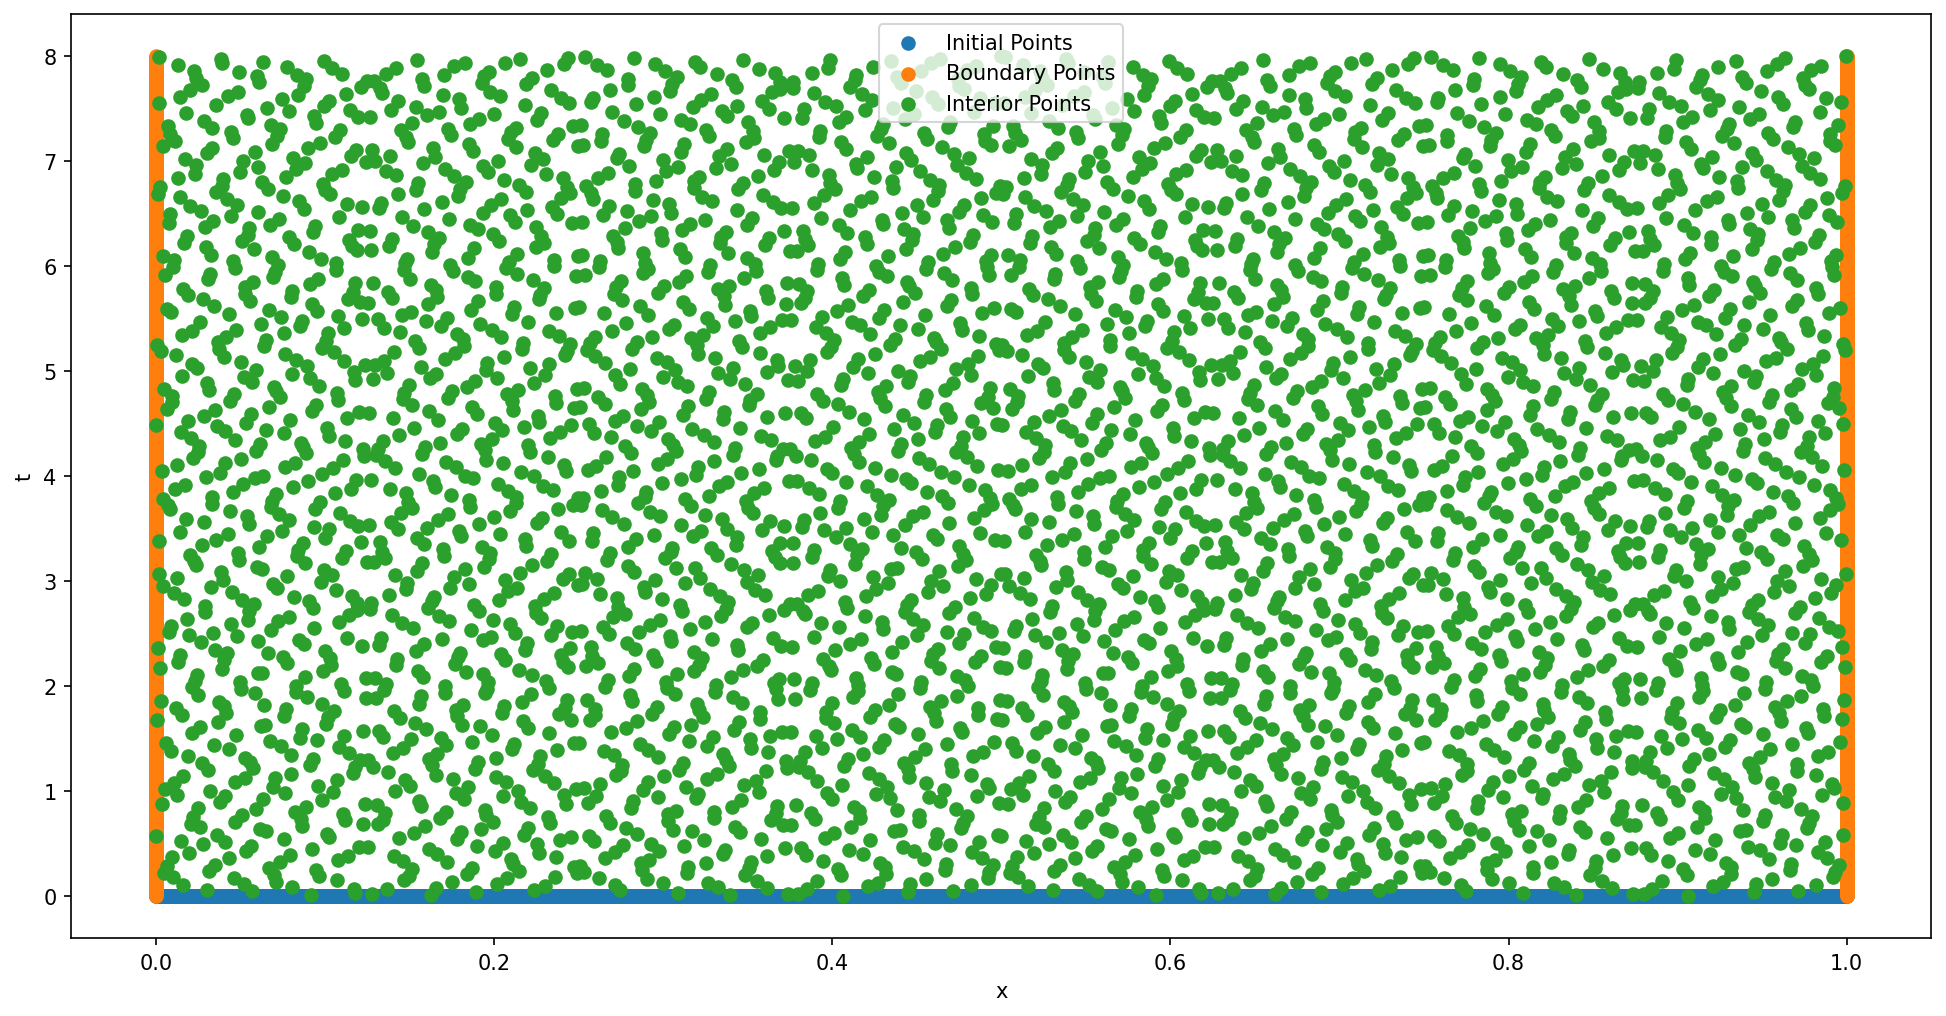

In [23]:
# Plot the Training Points
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)

plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")

plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [24]:
# Define the Optimizer
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution_fluid.parameters()) + list(pinn.approximate_solution_solid.parameters()) ,
                              lr=float(0.5),
                              max_iter=15000,
                              max_eval=150000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)


In [ ]:
# Train the PINN
n_epochs = 1
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

################################  0  ################################
Total loss:  0.0129 | Temporal Loss:  -7.2184 | Boundary Loss:  -5.2177 | Interior Loss:  -1.8893 | Measurement Loss:  -4.4986
Total loss:  0.0129 | Temporal Loss:  -7.1545 | Boundary Loss:  -5.2093 | Interior Loss:  -1.8901 | Measurement Loss:  -4.4964
Total loss:  0.0129 | Temporal Loss:  -7.1936 | Boundary Loss:  -5.2114 | Interior Loss:  -1.8903 | Measurement Loss:  -4.4962
Total loss:  0.0129 | Temporal Loss:  -7.2063 | Boundary Loss:  -5.2112 | Interior Loss:  -1.8905 | Measurement Loss:  -4.4959
Total loss:  0.0129 | Temporal Loss:  -7.2054 | Boundary Loss:  -5.2104 | Interior Loss:  -1.8906 | Measurement Loss:  -4.4957
Total loss:  0.0129 | Temporal Loss:  -7.2008 | Boundary Loss:  -5.2094 | Interior Loss:  -1.8907 | Measurement Loss:  -4.4955
Total loss:  0.0129 | Temporal Loss:  -7.1949 | Boundary Loss:  -5.2086 | Interior Loss:  -1.8908 | Measurement Loss:  -4.4952
Total loss:  0.0129 | Temporal Loss:  -7.

Total loss:  0.0128 | Temporal Loss:  -7.168 | Boundary Loss:  -5.2045 | Interior Loss:  -1.8932 | Measurement Loss:  -4.4891
Total loss:  0.0128 | Temporal Loss:  -7.1692 | Boundary Loss:  -5.2043 | Interior Loss:  -1.8932 | Measurement Loss:  -4.489
Total loss:  0.0128 | Temporal Loss:  -7.1685 | Boundary Loss:  -5.204 | Interior Loss:  -1.8933 | Measurement Loss:  -4.4889
Total loss:  0.0128 | Temporal Loss:  -7.1664 | Boundary Loss:  -5.2037 | Interior Loss:  -1.8933 | Measurement Loss:  -4.4888
Total loss:  0.0128 | Temporal Loss:  -7.163 | Boundary Loss:  -5.2034 | Interior Loss:  -1.8933 | Measurement Loss:  -4.4887
Total loss:  0.0128 | Temporal Loss:  -7.1585 | Boundary Loss:  -5.2032 | Interior Loss:  -1.8934 | Measurement Loss:  -4.4886
Total loss:  0.0128 | Temporal Loss:  -7.1515 | Boundary Loss:  -5.2032 | Interior Loss:  -1.8934 | Measurement Loss:  -4.4885
Total loss:  0.0128 | Temporal Loss:  -7.1262 | Boundary Loss:  -5.196 | Interior Loss:  -1.8936 | Measurement Loss

Total loss:  0.0128 | Temporal Loss:  -7.1631 | Boundary Loss:  -5.1994 | Interior Loss:  -1.8951 | Measurement Loss:  -4.4846
Total loss:  0.0128 | Temporal Loss:  -7.1644 | Boundary Loss:  -5.1994 | Interior Loss:  -1.8951 | Measurement Loss:  -4.4846
Total loss:  0.0128 | Temporal Loss:  -7.1652 | Boundary Loss:  -5.1992 | Interior Loss:  -1.8951 | Measurement Loss:  -4.4845
Total loss:  0.0128 | Temporal Loss:  -7.1654 | Boundary Loss:  -5.1992 | Interior Loss:  -1.8951 | Measurement Loss:  -4.4845
Total loss:  0.0128 | Temporal Loss:  -7.1649 | Boundary Loss:  -5.1991 | Interior Loss:  -1.8951 | Measurement Loss:  -4.4844
Total loss:  0.0128 | Temporal Loss:  -7.1635 | Boundary Loss:  -5.1991 | Interior Loss:  -1.8952 | Measurement Loss:  -4.4844
Total loss:  0.0128 | Temporal Loss:  -7.1611 | Boundary Loss:  -5.1991 | Interior Loss:  -1.8952 | Measurement Loss:  -4.4844
Total loss:  0.0128 | Temporal Loss:  -7.1569 | Boundary Loss:  -5.1991 | Interior Loss:  -1.8952 | Measurement

Total loss:  0.0127 | Temporal Loss:  -7.1245 | Boundary Loss:  -5.1994 | Interior Loss:  -1.8974 | Measurement Loss:  -4.4784
Total loss:  0.0127 | Temporal Loss:  -7.1274 | Boundary Loss:  -5.1994 | Interior Loss:  -1.8975 | Measurement Loss:  -4.4783
Total loss:  0.0127 | Temporal Loss:  -7.1304 | Boundary Loss:  -5.1995 | Interior Loss:  -1.8975 | Measurement Loss:  -4.4783
Total loss:  0.0127 | Temporal Loss:  -7.1334 | Boundary Loss:  -5.1995 | Interior Loss:  -1.8975 | Measurement Loss:  -4.4782
Total loss:  0.0127 | Temporal Loss:  -7.1363 | Boundary Loss:  -5.1995 | Interior Loss:  -1.8975 | Measurement Loss:  -4.478
Total loss:  0.0127 | Temporal Loss:  -7.1453 | Boundary Loss:  -5.1979 | Interior Loss:  -1.8973 | Measurement Loss:  -4.4786
Total loss:  0.0127 | Temporal Loss:  -7.1385 | Boundary Loss:  -5.1996 | Interior Loss:  -1.8975 | Measurement Loss:  -4.4781
Total loss:  0.0127 | Temporal Loss:  -7.1408 | Boundary Loss:  -5.1996 | Interior Loss:  -1.8976 | Measurement 

Total loss:  0.0127 | Temporal Loss:  -7.1505 | Boundary Loss:  -5.2023 | Interior Loss:  -1.8985 | Measurement Loss:  -4.4749
Total loss:  0.0127 | Temporal Loss:  -7.1508 | Boundary Loss:  -5.2019 | Interior Loss:  -1.8986 | Measurement Loss:  -4.4749
Total loss:  0.0127 | Temporal Loss:  -7.1505 | Boundary Loss:  -5.2012 | Interior Loss:  -1.8986 | Measurement Loss:  -4.4748
Total loss:  0.0127 | Temporal Loss:  -7.1504 | Boundary Loss:  -5.2006 | Interior Loss:  -1.8987 | Measurement Loss:  -4.4747
Total loss:  0.0127 | Temporal Loss:  -7.1497 | Boundary Loss:  -5.2001 | Interior Loss:  -1.8987 | Measurement Loss:  -4.4747
Total loss:  0.0127 | Temporal Loss:  -7.1485 | Boundary Loss:  -5.1998 | Interior Loss:  -1.8987 | Measurement Loss:  -4.4747
Total loss:  0.0127 | Temporal Loss:  -7.1461 | Boundary Loss:  -5.1995 | Interior Loss:  -1.8988 | Measurement Loss:  -4.4746
Total loss:  0.0127 | Temporal Loss:  -7.1471 | Boundary Loss:  -5.1985 | Interior Loss:  -1.8989 | Measurement

Total loss:  0.0126 | Temporal Loss:  -7.115 | Boundary Loss:  -5.1946 | Interior Loss:  -1.9003 | Measurement Loss:  -4.471
Total loss:  0.0126 | Temporal Loss:  -7.116 | Boundary Loss:  -5.1947 | Interior Loss:  -1.9003 | Measurement Loss:  -4.471
Total loss:  0.0126 | Temporal Loss:  -7.1149 | Boundary Loss:  -5.1948 | Interior Loss:  -1.9004 | Measurement Loss:  -4.4709
Total loss:  0.0126 | Temporal Loss:  -7.1144 | Boundary Loss:  -5.1949 | Interior Loss:  -1.9004 | Measurement Loss:  -4.4709
Total loss:  0.0126 | Temporal Loss:  -7.1115 | Boundary Loss:  -5.1949 | Interior Loss:  -1.9004 | Measurement Loss:  -4.4708
Total loss:  0.0126 | Temporal Loss:  -7.1107 | Boundary Loss:  -5.1943 | Interior Loss:  -1.9005 | Measurement Loss:  -4.4705
Total loss:  0.0126 | Temporal Loss:  -7.1092 | Boundary Loss:  -5.1945 | Interior Loss:  -1.9005 | Measurement Loss:  -4.4705
Total loss:  0.0126 | Temporal Loss:  -7.1078 | Boundary Loss:  -5.1945 | Interior Loss:  -1.9006 | Measurement Los

Total loss:  0.0126 | Temporal Loss:  -7.1382 | Boundary Loss:  -5.193 | Interior Loss:  -1.9017 | Measurement Loss:  -4.4674
Total loss:  0.0126 | Temporal Loss:  -7.0983 | Boundary Loss:  -5.1827 | Interior Loss:  -1.9022 | Measurement Loss:  -4.4643
Total loss:  0.0126 | Temporal Loss:  -7.1381 | Boundary Loss:  -5.193 | Interior Loss:  -1.9018 | Measurement Loss:  -4.4672
Total loss:  0.0126 | Temporal Loss:  -7.1384 | Boundary Loss:  -5.1931 | Interior Loss:  -1.9018 | Measurement Loss:  -4.4672
Total loss:  0.0126 | Temporal Loss:  -7.1389 | Boundary Loss:  -5.1933 | Interior Loss:  -1.9018 | Measurement Loss:  -4.4671
Total loss:  0.0126 | Temporal Loss:  -7.1393 | Boundary Loss:  -5.1935 | Interior Loss:  -1.9018 | Measurement Loss:  -4.4671
Total loss:  0.0126 | Temporal Loss:  -7.1397 | Boundary Loss:  -5.1937 | Interior Loss:  -1.9018 | Measurement Loss:  -4.4671
Total loss:  0.0126 | Temporal Loss:  -7.14 | Boundary Loss:  -5.1939 | Interior Loss:  -1.9018 | Measurement Los

Total loss:  0.0125 | Temporal Loss:  -7.1614 | Boundary Loss:  -5.1934 | Interior Loss:  -1.9031 | Measurement Loss:  -4.4636
Total loss:  0.0125 | Temporal Loss:  -7.1587 | Boundary Loss:  -5.1936 | Interior Loss:  -1.9032 | Measurement Loss:  -4.4636
Total loss:  0.0125 | Temporal Loss:  -7.1553 | Boundary Loss:  -5.1938 | Interior Loss:  -1.9032 | Measurement Loss:  -4.4634
Total loss:  0.0125 | Temporal Loss:  -7.1523 | Boundary Loss:  -5.1936 | Interior Loss:  -1.9032 | Measurement Loss:  -4.4633
Total loss:  0.0125 | Temporal Loss:  -7.1478 | Boundary Loss:  -5.1934 | Interior Loss:  -1.9033 | Measurement Loss:  -4.4633
Total loss:  0.0125 | Temporal Loss:  -7.1426 | Boundary Loss:  -5.1932 | Interior Loss:  -1.9033 | Measurement Loss:  -4.4633
Total loss:  0.0125 | Temporal Loss:  -7.1377 | Boundary Loss:  -5.193 | Interior Loss:  -1.9033 | Measurement Loss:  -4.4632
Total loss:  0.0125 | Temporal Loss:  -7.1326 | Boundary Loss:  -5.1928 | Interior Loss:  -1.9034 | Measurement 

Total loss:  0.0125 | Temporal Loss:  -7.1192 | Boundary Loss:  -5.1944 | Interior Loss:  -1.9047 | Measurement Loss:  -4.4595
Total loss:  0.0125 | Temporal Loss:  -7.119 | Boundary Loss:  -5.1946 | Interior Loss:  -1.9047 | Measurement Loss:  -4.4594
Total loss:  0.0125 | Temporal Loss:  -7.1197 | Boundary Loss:  -5.1947 | Interior Loss:  -1.9048 | Measurement Loss:  -4.4593
Total loss:  0.0125 | Temporal Loss:  -7.1217 | Boundary Loss:  -5.1947 | Interior Loss:  -1.9048 | Measurement Loss:  -4.4593
Total loss:  0.0125 | Temporal Loss:  -7.1238 | Boundary Loss:  -5.1948 | Interior Loss:  -1.9048 | Measurement Loss:  -4.4593
Total loss:  0.0125 | Temporal Loss:  -7.1258 | Boundary Loss:  -5.1948 | Interior Loss:  -1.9048 | Measurement Loss:  -4.4593
Total loss:  0.0125 | Temporal Loss:  -7.1285 | Boundary Loss:  -5.1952 | Interior Loss:  -1.9048 | Measurement Loss:  -4.4592
Total loss:  0.0125 | Temporal Loss:  -7.1279 | Boundary Loss:  -5.1951 | Interior Loss:  -1.9048 | Measurement 

Total loss:  0.0125 | Temporal Loss:  -7.1055 | Boundary Loss:  -5.1949 | Interior Loss:  -1.9054 | Measurement Loss:  -4.4581
Total loss:  0.0125 | Temporal Loss:  -7.1109 | Boundary Loss:  -5.1955 | Interior Loss:  -1.9055 | Measurement Loss:  -4.4583
Total loss:  0.0125 | Temporal Loss:  -7.1112 | Boundary Loss:  -5.1956 | Interior Loss:  -1.9055 | Measurement Loss:  -4.4583
Total loss:  0.0125 | Temporal Loss:  -7.1092 | Boundary Loss:  -5.1957 | Interior Loss:  -1.9055 | Measurement Loss:  -4.4583
Total loss:  0.0125 | Temporal Loss:  -7.1083 | Boundary Loss:  -5.1955 | Interior Loss:  -1.9055 | Measurement Loss:  -4.4582
Total loss:  0.0125 | Temporal Loss:  -7.1058 | Boundary Loss:  -5.1954 | Interior Loss:  -1.9056 | Measurement Loss:  -4.4582
Total loss:  0.0125 | Temporal Loss:  -7.1024 | Boundary Loss:  -5.1951 | Interior Loss:  -1.9056 | Measurement Loss:  -4.458
Total loss:  0.0125 | Temporal Loss:  -7.0954 | Boundary Loss:  -5.1953 | Interior Loss:  -1.9055 | Measurement 

Total loss:  0.0124 | Temporal Loss:  -7.0945 | Boundary Loss:  -5.1914 | Interior Loss:  -1.9065 | Measurement Loss:  -4.4568
Total loss:  0.0124 | Temporal Loss:  -7.095 | Boundary Loss:  -5.1915 | Interior Loss:  -1.9065 | Measurement Loss:  -4.4567
Total loss:  0.0124 | Temporal Loss:  -7.1027 | Boundary Loss:  -5.1886 | Interior Loss:  -1.9064 | Measurement Loss:  -4.4571
Total loss:  0.0124 | Temporal Loss:  -7.0967 | Boundary Loss:  -5.1914 | Interior Loss:  -1.9065 | Measurement Loss:  -4.4567
Total loss:  0.0124 | Temporal Loss:  -7.0965 | Boundary Loss:  -5.1914 | Interior Loss:  -1.9066 | Measurement Loss:  -4.4566
Total loss:  0.0124 | Temporal Loss:  -7.0974 | Boundary Loss:  -5.1913 | Interior Loss:  -1.9066 | Measurement Loss:  -4.4564
Total loss:  0.0124 | Temporal Loss:  -7.0961 | Boundary Loss:  -5.1913 | Interior Loss:  -1.9066 | Measurement Loss:  -4.4563
Total loss:  0.0124 | Temporal Loss:  -7.0936 | Boundary Loss:  -5.1911 | Interior Loss:  -1.9067 | Measurement 

Total loss:  0.0124 | Temporal Loss:  -7.0977 | Boundary Loss:  -5.1889 | Interior Loss:  -1.9075 | Measurement Loss:  -4.4545
Total loss:  0.0124 | Temporal Loss:  -7.0973 | Boundary Loss:  -5.1889 | Interior Loss:  -1.9075 | Measurement Loss:  -4.4544
Total loss:  0.0124 | Temporal Loss:  -7.0967 | Boundary Loss:  -5.1889 | Interior Loss:  -1.9075 | Measurement Loss:  -4.4543
Total loss:  0.0124 | Temporal Loss:  -7.0957 | Boundary Loss:  -5.1889 | Interior Loss:  -1.9075 | Measurement Loss:  -4.4541
Total loss:  0.0124 | Temporal Loss:  -7.0939 | Boundary Loss:  -5.1888 | Interior Loss:  -1.9077 | Measurement Loss:  -4.4536
Total loss:  0.0124 | Temporal Loss:  -7.0932 | Boundary Loss:  -5.1888 | Interior Loss:  -1.9077 | Measurement Loss:  -4.4536
Total loss:  0.0124 | Temporal Loss:  -7.0921 | Boundary Loss:  -5.189 | Interior Loss:  -1.9077 | Measurement Loss:  -4.4535
Total loss:  0.0124 | Temporal Loss:  -7.0904 | Boundary Loss:  -5.1892 | Interior Loss:  -1.9077 | Measurement 

Total loss:  0.0124 | Temporal Loss:  -7.0525 | Boundary Loss:  -5.1868 | Interior Loss:  -1.9089 | Measurement Loss:  -4.4508
Total loss:  0.0124 | Temporal Loss:  -7.0606 | Boundary Loss:  -5.1874 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4514
Total loss:  0.0124 | Temporal Loss:  -7.0603 | Boundary Loss:  -5.1875 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4514
Total loss:  0.0124 | Temporal Loss:  -7.0604 | Boundary Loss:  -5.1875 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4514
Total loss:  0.0124 | Temporal Loss:  -7.0592 | Boundary Loss:  -5.1877 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4514
Total loss:  0.0124 | Temporal Loss:  -7.059 | Boundary Loss:  -5.1877 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4515
Total loss:  0.0124 | Temporal Loss:  -7.0615 | Boundary Loss:  -5.1877 | Interior Loss:  -1.9088 | Measurement Loss:  -4.4514
Total loss:  0.0124 | Temporal Loss:  -7.0604 | Boundary Loss:  -5.1878 | Interior Loss:  -1.9088 | Measurement 

Total loss:  0.0124 | Temporal Loss:  -7.0445 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4508
Total loss:  0.0124 | Temporal Loss:  -7.0442 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4509
Total loss:  0.0124 | Temporal Loss:  -7.0442 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4509
Total loss:  0.0124 | Temporal Loss:  -7.0446 | Boundary Loss:  -5.186 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4507
Total loss:  0.0124 | Temporal Loss:  -7.0445 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4507
Total loss:  0.0124 | Temporal Loss:  -7.0438 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4507
Total loss:  0.0124 | Temporal Loss:  -7.0428 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9094 | Measurement Loss:  -4.4507
Total loss:  0.0124 | Temporal Loss:  -7.0412 | Boundary Loss:  -5.1859 | Interior Loss:  -1.9095 | Measurement 

Total loss:  0.0123 | Temporal Loss:  -7.034 | Boundary Loss:  -5.1843 | Interior Loss:  -1.9105 | Measurement Loss:  -4.4485
Total loss:  0.0123 | Temporal Loss:  -7.0321 | Boundary Loss:  -5.1843 | Interior Loss:  -1.9106 | Measurement Loss:  -4.4484
Total loss:  0.0123 | Temporal Loss:  -7.0294 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9106 | Measurement Loss:  -4.4483
Total loss:  0.0123 | Temporal Loss:  -7.0266 | Boundary Loss:  -5.1841 | Interior Loss:  -1.9106 | Measurement Loss:  -4.4483
Total loss:  0.0123 | Temporal Loss:  -7.0241 | Boundary Loss:  -5.1841 | Interior Loss:  -1.9106 | Measurement Loss:  -4.4484
Total loss:  0.0123 | Temporal Loss:  -7.0204 | Boundary Loss:  -5.1839 | Interior Loss:  -1.9107 | Measurement Loss:  -4.4484
Total loss:  0.0123 | Temporal Loss:  -7.0194 | Boundary Loss:  -5.184 | Interior Loss:  -1.9106 | Measurement Loss:  -4.4485
Total loss:  0.0123 | Temporal Loss:  -7.0186 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9106 | Measurement L

Total loss:  0.0123 | Temporal Loss:  -6.9991 | Boundary Loss:  -5.184 | Interior Loss:  -1.9114 | Measurement Loss:  -4.4477
Total loss:  0.0123 | Temporal Loss:  -7.0011 | Boundary Loss:  -5.1841 | Interior Loss:  -1.9114 | Measurement Loss:  -4.4477
Total loss:  0.0123 | Temporal Loss:  -7.0032 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9114 | Measurement Loss:  -4.4477
Total loss:  0.0123 | Temporal Loss:  -7.0054 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9114 | Measurement Loss:  -4.4476
Total loss:  0.0123 | Temporal Loss:  -7.0076 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9115 | Measurement Loss:  -4.4474
Total loss:  0.0123 | Temporal Loss:  -7.0088 | Boundary Loss:  -5.1843 | Interior Loss:  -1.9115 | Measurement Loss:  -4.4474
Total loss:  0.0123 | Temporal Loss:  -7.01 | Boundary Loss:  -5.1843 | Interior Loss:  -1.9115 | Measurement Loss:  -4.4475
Total loss:  0.0123 | Temporal Loss:  -7.0108 | Boundary Loss:  -5.1842 | Interior Loss:  -1.9115 | Measurement Lo

Total loss:  0.0123 | Temporal Loss:  -6.9788 | Boundary Loss:  -5.1808 | Interior Loss:  -1.9126 | Measurement Loss:  -4.4451
Total loss:  0.0122 | Temporal Loss:  -6.9059 | Boundary Loss:  -5.1656 | Interior Loss:  -1.9136 | Measurement Loss:  -4.4399
Total loss:  0.0123 | Temporal Loss:  -6.9781 | Boundary Loss:  -5.1807 | Interior Loss:  -1.9126 | Measurement Loss:  -4.4449
Total loss:  0.0123 | Temporal Loss:  -6.9796 | Boundary Loss:  -5.1807 | Interior Loss:  -1.9126 | Measurement Loss:  -4.445
Total loss:  0.0123 | Temporal Loss:  -6.9805 | Boundary Loss:  -5.1806 | Interior Loss:  -1.9126 | Measurement Loss:  -4.4451
Total loss:  0.0123 | Temporal Loss:  -6.9815 | Boundary Loss:  -5.1805 | Interior Loss:  -1.9126 | Measurement Loss:  -4.4451
Total loss:  0.0123 | Temporal Loss:  -6.9801 | Boundary Loss:  -5.1803 | Interior Loss:  -1.9127 | Measurement Loss:  -4.4452
Total loss:  0.0123 | Temporal Loss:  -6.98 | Boundary Loss:  -5.1801 | Interior Loss:  -1.9127 | Measurement Lo

Total loss:  0.0122 | Temporal Loss:  -7.0002 | Boundary Loss:  -5.178 | Interior Loss:  -1.9141 | Measurement Loss:  -4.4414
Total loss:  0.0122 | Temporal Loss:  -7.0008 | Boundary Loss:  -5.1777 | Interior Loss:  -1.9142 | Measurement Loss:  -4.4412
Total loss:  0.0122 | Temporal Loss:  -6.9997 | Boundary Loss:  -5.1775 | Interior Loss:  -1.9142 | Measurement Loss:  -4.441
Total loss:  0.0122 | Temporal Loss:  -6.99 | Boundary Loss:  -5.1761 | Interior Loss:  -1.9144 | Measurement Loss:  -4.4404
Total loss:  0.0122 | Temporal Loss:  -6.9978 | Boundary Loss:  -5.1771 | Interior Loss:  -1.9143 | Measurement Loss:  -4.4408
Total loss:  0.0122 | Temporal Loss:  -6.9987 | Boundary Loss:  -5.1773 | Interior Loss:  -1.9143 | Measurement Loss:  -4.4407
Total loss:  0.0122 | Temporal Loss:  -6.9998 | Boundary Loss:  -5.1775 | Interior Loss:  -1.9143 | Measurement Loss:  -4.4407
Total loss:  0.0122 | Temporal Loss:  -7.001 | Boundary Loss:  -5.1778 | Interior Loss:  -1.9143 | Measurement Loss

Total loss:  0.0122 | Temporal Loss:  -7.018 | Boundary Loss:  -5.1731 | Interior Loss:  -1.9148 | Measurement Loss:  -4.4411
Total loss:  0.0122 | Temporal Loss:  -7.0155 | Boundary Loss:  -5.1731 | Interior Loss:  -1.9149 | Measurement Loss:  -4.4409
Total loss:  0.0122 | Temporal Loss:  -7.0144 | Boundary Loss:  -5.173 | Interior Loss:  -1.9149 | Measurement Loss:  -4.4409
Total loss:  0.0122 | Temporal Loss:  -7.0139 | Boundary Loss:  -5.1729 | Interior Loss:  -1.9149 | Measurement Loss:  -4.441
Total loss:  0.0122 | Temporal Loss:  -7.0133 | Boundary Loss:  -5.1729 | Interior Loss:  -1.9149 | Measurement Loss:  -4.441
Total loss:  0.0122 | Temporal Loss:  -7.0127 | Boundary Loss:  -5.1728 | Interior Loss:  -1.9149 | Measurement Loss:  -4.4411
Total loss:  0.0122 | Temporal Loss:  -7.0122 | Boundary Loss:  -5.1728 | Interior Loss:  -1.9149 | Measurement Loss:  -4.4411
Total loss:  0.0122 | Temporal Loss:  -7.012 | Boundary Loss:  -5.1728 | Interior Loss:  -1.9149 | Measurement Loss

Total loss:  0.0122 | Temporal Loss:  -6.9814 | Boundary Loss:  -5.1713 | Interior Loss:  -1.9157 | Measurement Loss:  -4.4401
Total loss:  0.0122 | Temporal Loss:  -6.9798 | Boundary Loss:  -5.1714 | Interior Loss:  -1.9158 | Measurement Loss:  -4.4399
Total loss:  0.0122 | Temporal Loss:  -6.9785 | Boundary Loss:  -5.1713 | Interior Loss:  -1.9159 | Measurement Loss:  -4.4396
Total loss:  0.0122 | Temporal Loss:  -6.9788 | Boundary Loss:  -5.1711 | Interior Loss:  -1.9159 | Measurement Loss:  -4.4394
Total loss:  0.0122 | Temporal Loss:  -6.9791 | Boundary Loss:  -5.1709 | Interior Loss:  -1.916 | Measurement Loss:  -4.4392
Total loss:  0.0122 | Temporal Loss:  -6.9804 | Boundary Loss:  -5.1708 | Interior Loss:  -1.9161 | Measurement Loss:  -4.439
Total loss:  0.0122 | Temporal Loss:  -6.9808 | Boundary Loss:  -5.1704 | Interior Loss:  -1.9161 | Measurement Loss:  -4.4388
Total loss:  0.0122 | Temporal Loss:  -6.9819 | Boundary Loss:  -5.1705 | Interior Loss:  -1.9161 | Measurement L

Total loss:  0.0122 | Temporal Loss:  -6.9671 | Boundary Loss:  -5.1719 | Interior Loss:  -1.9167 | Measurement Loss:  -4.4378
Total loss:  0.0122 | Temporal Loss:  -6.9701 | Boundary Loss:  -5.1721 | Interior Loss:  -1.9167 | Measurement Loss:  -4.4378
Total loss:  0.0122 | Temporal Loss:  -6.9721 | Boundary Loss:  -5.1721 | Interior Loss:  -1.9167 | Measurement Loss:  -4.4378
Total loss:  0.0122 | Temporal Loss:  -6.9732 | Boundary Loss:  -5.1721 | Interior Loss:  -1.9167 | Measurement Loss:  -4.4378
Total loss:  0.0122 | Temporal Loss:  -6.9738 | Boundary Loss:  -5.1721 | Interior Loss:  -1.9168 | Measurement Loss:  -4.4378
Total loss:  0.0122 | Temporal Loss:  -6.9742 | Boundary Loss:  -5.172 | Interior Loss:  -1.9168 | Measurement Loss:  -4.4377
Total loss:  0.0122 | Temporal Loss:  -6.9714 | Boundary Loss:  -5.1719 | Interior Loss:  -1.9168 | Measurement Loss:  -4.4377
Total loss:  0.0122 | Temporal Loss:  -6.973 | Boundary Loss:  -5.172 | Interior Loss:  -1.9168 | Measurement Lo

Total loss:  0.0121 | Temporal Loss:  -6.9731 | Boundary Loss:  -5.1697 | Interior Loss:  -1.9176 | Measurement Loss:  -4.437
Total loss:  0.0121 | Temporal Loss:  -6.9691 | Boundary Loss:  -5.1711 | Interior Loss:  -1.9173 | Measurement Loss:  -4.4377
Total loss:  0.0121 | Temporal Loss:  -6.9729 | Boundary Loss:  -5.17 | Interior Loss:  -1.9176 | Measurement Loss:  -4.4371
Total loss:  0.0121 | Temporal Loss:  -6.9729 | Boundary Loss:  -5.1696 | Interior Loss:  -1.9176 | Measurement Loss:  -4.437
Total loss:  0.0121 | Temporal Loss:  -6.9738 | Boundary Loss:  -5.1691 | Interior Loss:  -1.9177 | Measurement Loss:  -4.4369
Total loss:  0.0121 | Temporal Loss:  -6.9755 | Boundary Loss:  -5.1687 | Interior Loss:  -1.9177 | Measurement Loss:  -4.4368
Total loss:  0.0121 | Temporal Loss:  -6.9722 | Boundary Loss:  -5.1677 | Interior Loss:  -1.9177 | Measurement Loss:  -4.437
Total loss:  0.0121 | Temporal Loss:  -6.975 | Boundary Loss:  -5.1686 | Interior Loss:  -1.9177 | Measurement Loss:

Total loss:  0.0121 | Temporal Loss:  -6.9485 | Boundary Loss:  -5.1654 | Interior Loss:  -1.9189 | Measurement Loss:  -4.4348
Total loss:  0.0121 | Temporal Loss:  -6.947 | Boundary Loss:  -5.1655 | Interior Loss:  -1.9189 | Measurement Loss:  -4.4347
Total loss:  0.0121 | Temporal Loss:  -6.9464 | Boundary Loss:  -5.1655 | Interior Loss:  -1.9189 | Measurement Loss:  -4.4347
Total loss:  0.0121 | Temporal Loss:  -6.9501 | Boundary Loss:  -5.1654 | Interior Loss:  -1.919 | Measurement Loss:  -4.4346
Total loss:  0.0121 | Temporal Loss:  -6.9492 | Boundary Loss:  -5.1654 | Interior Loss:  -1.919 | Measurement Loss:  -4.4346
Total loss:  0.0121 | Temporal Loss:  -6.9498 | Boundary Loss:  -5.1654 | Interior Loss:  -1.919 | Measurement Loss:  -4.4346
Total loss:  0.0121 | Temporal Loss:  -6.9514 | Boundary Loss:  -5.1653 | Interior Loss:  -1.919 | Measurement Loss:  -4.4346
Total loss:  0.0121 | Temporal Loss:  -6.9542 | Boundary Loss:  -5.1653 | Interior Loss:  -1.919 | Measurement Loss:

Total loss:  0.0121 | Temporal Loss:  -7.0009 | Boundary Loss:  -5.167 | Interior Loss:  -1.9195 | Measurement Loss:  -4.4332
Total loss:  0.0121 | Temporal Loss:  -7.0007 | Boundary Loss:  -5.167 | Interior Loss:  -1.9195 | Measurement Loss:  -4.4332
Total loss:  0.0121 | Temporal Loss:  -7.0002 | Boundary Loss:  -5.1671 | Interior Loss:  -1.9195 | Measurement Loss:  -4.4333
Total loss:  0.0121 | Temporal Loss:  -7.0002 | Boundary Loss:  -5.1672 | Interior Loss:  -1.9195 | Measurement Loss:  -4.4334
Total loss:  0.0121 | Temporal Loss:  -7.0017 | Boundary Loss:  -5.1673 | Interior Loss:  -1.9194 | Measurement Loss:  -4.4336
Total loss:  0.0121 | Temporal Loss:  -6.9992 | Boundary Loss:  -5.1677 | Interior Loss:  -1.9194 | Measurement Loss:  -4.4338
Total loss:  0.0121 | Temporal Loss:  -7.0023 | Boundary Loss:  -5.1677 | Interior Loss:  -1.9194 | Measurement Loss:  -4.4339
Total loss:  0.0121 | Temporal Loss:  -7.0044 | Boundary Loss:  -5.1678 | Interior Loss:  -1.9193 | Measurement L

Total loss:  0.012 | Temporal Loss:  -7.0403 | Boundary Loss:  -5.1655 | Interior Loss:  -1.9207 | Measurement Loss:  -4.4304
Total loss:  0.012 | Temporal Loss:  -7.0402 | Boundary Loss:  -5.1654 | Interior Loss:  -1.9208 | Measurement Loss:  -4.4303
Total loss:  0.012 | Temporal Loss:  -7.0405 | Boundary Loss:  -5.1653 | Interior Loss:  -1.9208 | Measurement Loss:  -4.4302
Total loss:  0.012 | Temporal Loss:  -7.0405 | Boundary Loss:  -5.1651 | Interior Loss:  -1.9208 | Measurement Loss:  -4.4301
Total loss:  0.012 | Temporal Loss:  -7.041 | Boundary Loss:  -5.165 | Interior Loss:  -1.9209 | Measurement Loss:  -4.43
Total loss:  0.012 | Temporal Loss:  -7.0416 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9209 | Measurement Loss:  -4.43
Total loss:  0.012 | Temporal Loss:  -7.0412 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9209 | Measurement Loss:  -4.4299
Total loss:  0.012 | Temporal Loss:  -7.0409 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9209 | Measurement Loss:  -4.429

Total loss:  0.012 | Temporal Loss:  -7.0562 | Boundary Loss:  -5.1652 | Interior Loss:  -1.9211 | Measurement Loss:  -4.4306
Total loss:  0.012 | Temporal Loss:  -7.0558 | Boundary Loss:  -5.1652 | Interior Loss:  -1.9212 | Measurement Loss:  -4.4305
Total loss:  0.012 | Temporal Loss:  -7.0555 | Boundary Loss:  -5.1653 | Interior Loss:  -1.9212 | Measurement Loss:  -4.4304
Total loss:  0.012 | Temporal Loss:  -7.0556 | Boundary Loss:  -5.1654 | Interior Loss:  -1.9212 | Measurement Loss:  -4.4303
Total loss:  0.012 | Temporal Loss:  -7.0563 | Boundary Loss:  -5.1656 | Interior Loss:  -1.9212 | Measurement Loss:  -4.4301
Total loss:  0.012 | Temporal Loss:  -7.056 | Boundary Loss:  -5.1657 | Interior Loss:  -1.9213 | Measurement Loss:  -4.43
Total loss:  0.012 | Temporal Loss:  -6.9973 | Boundary Loss:  -5.149 | Interior Loss:  -1.9218 | Measurement Loss:  -4.4264
Total loss:  0.012 | Temporal Loss:  -7.0569 | Boundary Loss:  -5.1658 | Interior Loss:  -1.9213 | Measurement Loss:  -4.4

Total loss:  0.012 | Temporal Loss:  -7.0589 | Boundary Loss:  -5.1676 | Interior Loss:  -1.9219 | Measurement Loss:  -4.4285
Total loss:  0.012 | Temporal Loss:  -7.062 | Boundary Loss:  -5.1668 | Interior Loss:  -1.9219 | Measurement Loss:  -4.4283
Total loss:  0.012 | Temporal Loss:  -7.0596 | Boundary Loss:  -5.1665 | Interior Loss:  -1.922 | Measurement Loss:  -4.4282
Total loss:  0.012 | Temporal Loss:  -7.0587 | Boundary Loss:  -5.1665 | Interior Loss:  -1.922 | Measurement Loss:  -4.4282
Total loss:  0.012 | Temporal Loss:  -7.0574 | Boundary Loss:  -5.1666 | Interior Loss:  -1.922 | Measurement Loss:  -4.4283
Total loss:  0.012 | Temporal Loss:  -7.056 | Boundary Loss:  -5.1668 | Interior Loss:  -1.922 | Measurement Loss:  -4.4283
Total loss:  0.012 | Temporal Loss:  -7.0544 | Boundary Loss:  -5.1669 | Interior Loss:  -1.922 | Measurement Loss:  -4.4284
Total loss:  0.012 | Temporal Loss:  -7.0528 | Boundary Loss:  -5.167 | Interior Loss:  -1.9219 | Measurement Loss:  -4.4285


Total loss:  0.012 | Temporal Loss:  -7.0308 | Boundary Loss:  -5.1638 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4243
Total loss:  0.012 | Temporal Loss:  -7.0317 | Boundary Loss:  -5.1638 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4244
Total loss:  0.012 | Temporal Loss:  -7.0299 | Boundary Loss:  -5.1636 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4243
Total loss:  0.012 | Temporal Loss:  -7.032 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4245
Total loss:  0.012 | Temporal Loss:  -7.0336 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4245
Total loss:  0.012 | Temporal Loss:  -7.0344 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4246
Total loss:  0.012 | Temporal Loss:  -7.0335 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4246
Total loss:  0.012 | Temporal Loss:  -7.0322 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9237 | Measurement Loss:  -

Total loss:  0.012 | Temporal Loss:  -7.0392 | Boundary Loss:  -5.1623 | Interior Loss:  -1.9237 | Measurement Loss:  -4.4269
Total loss:  0.012 | Temporal Loss:  -7.0367 | Boundary Loss:  -5.163 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4265
Total loss:  0.012 | Temporal Loss:  -7.0376 | Boundary Loss:  -5.1631 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4266
Total loss:  0.012 | Temporal Loss:  -7.0381 | Boundary Loss:  -5.1632 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4267
Total loss:  0.012 | Temporal Loss:  -7.038 | Boundary Loss:  -5.1634 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4267
Total loss:  0.012 | Temporal Loss:  -7.0376 | Boundary Loss:  -5.1635 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4266
Total loss:  0.012 | Temporal Loss:  -7.0368 | Boundary Loss:  -5.1635 | Interior Loss:  -1.9238 | Measurement Loss:  -4.4265
Total loss:  0.012 | Temporal Loss:  -7.0246 | Boundary Loss:  -5.162 | Interior Loss:  -1.9239 | Measurement Loss:  -4.

Total loss:  0.0119 | Temporal Loss:  -7.0238 | Boundary Loss:  -5.1631 | Interior Loss:  -1.9248 | Measurement Loss:  -4.4245
Total loss:  0.0119 | Temporal Loss:  -7.0224 | Boundary Loss:  -5.1628 | Interior Loss:  -1.9249 | Measurement Loss:  -4.4245
Total loss:  0.0119 | Temporal Loss:  -7.0209 | Boundary Loss:  -5.1626 | Interior Loss:  -1.9249 | Measurement Loss:  -4.4244
Total loss:  0.0119 | Temporal Loss:  -7.0195 | Boundary Loss:  -5.1622 | Interior Loss:  -1.925 | Measurement Loss:  -4.4243
Total loss:  0.0119 | Temporal Loss:  -7.0188 | Boundary Loss:  -5.1619 | Interior Loss:  -1.925 | Measurement Loss:  -4.4242
Total loss:  0.0119 | Temporal Loss:  -7.0182 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9251 | Measurement Loss:  -4.4241
Total loss:  0.0119 | Temporal Loss:  -7.0184 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9251 | Measurement Loss:  -4.4241
Total loss:  0.0119 | Temporal Loss:  -7.0189 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9251 | Measurement L

Total loss:  0.0119 | Temporal Loss:  -6.9915 | Boundary Loss:  -5.161 | Interior Loss:  -1.926 | Measurement Loss:  -4.4219
Total loss:  0.0119 | Temporal Loss:  -6.9924 | Boundary Loss:  -5.1608 | Interior Loss:  -1.926 | Measurement Loss:  -4.422
Total loss:  0.0119 | Temporal Loss:  -6.9919 | Boundary Loss:  -5.1608 | Interior Loss:  -1.926 | Measurement Loss:  -4.422
Total loss:  0.0119 | Temporal Loss:  -6.9906 | Boundary Loss:  -5.1606 | Interior Loss:  -1.926 | Measurement Loss:  -4.422
Total loss:  0.0119 | Temporal Loss:  -6.9905 | Boundary Loss:  -5.1607 | Interior Loss:  -1.926 | Measurement Loss:  -4.4221
Total loss:  0.0119 | Temporal Loss:  -6.9875 | Boundary Loss:  -5.1605 | Interior Loss:  -1.926 | Measurement Loss:  -4.4221
Total loss:  0.0119 | Temporal Loss:  -6.9894 | Boundary Loss:  -5.1605 | Interior Loss:  -1.926 | Measurement Loss:  -4.4221
Total loss:  0.0119 | Temporal Loss:  -6.9899 | Boundary Loss:  -5.1603 | Interior Loss:  -1.9261 | Measurement Loss:  -4.

Total loss:  0.0119 | Temporal Loss:  -6.9927 | Boundary Loss:  -5.1552 | Interior Loss:  -1.9271 | Measurement Loss:  -4.4202
Total loss:  0.0119 | Temporal Loss:  -6.9905 | Boundary Loss:  -5.1553 | Interior Loss:  -1.9271 | Measurement Loss:  -4.4202
Total loss:  0.0119 | Temporal Loss:  -6.9876 | Boundary Loss:  -5.1555 | Interior Loss:  -1.9271 | Measurement Loss:  -4.4202
Total loss:  0.0119 | Temporal Loss:  -6.9869 | Boundary Loss:  -5.1554 | Interior Loss:  -1.9272 | Measurement Loss:  -4.4201
Total loss:  0.0119 | Temporal Loss:  -6.9859 | Boundary Loss:  -5.1555 | Interior Loss:  -1.9272 | Measurement Loss:  -4.4201
Total loss:  0.0119 | Temporal Loss:  -6.9853 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9272 | Measurement Loss:  -4.42
Total loss:  0.0119 | Temporal Loss:  -6.9848 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9272 | Measurement Loss:  -4.42
Total loss:  0.0119 | Temporal Loss:  -6.9845 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9272 | Measurement Los

Total loss:  0.0119 | Temporal Loss:  -6.9971 | Boundary Loss:  -5.1555 | Interior Loss:  -1.9274 | Measurement Loss:  -4.421
Total loss:  0.0119 | Temporal Loss:  -6.996 | Boundary Loss:  -5.1554 | Interior Loss:  -1.9274 | Measurement Loss:  -4.421
Total loss:  0.0119 | Temporal Loss:  -6.9953 | Boundary Loss:  -5.1553 | Interior Loss:  -1.9274 | Measurement Loss:  -4.4209
Total loss:  0.0119 | Temporal Loss:  -6.9949 | Boundary Loss:  -5.1552 | Interior Loss:  -1.9275 | Measurement Loss:  -4.4209
Total loss:  0.0119 | Temporal Loss:  -6.9946 | Boundary Loss:  -5.1551 | Interior Loss:  -1.9275 | Measurement Loss:  -4.4209
Total loss:  0.0119 | Temporal Loss:  -6.9898 | Boundary Loss:  -5.1515 | Interior Loss:  -1.9276 | Measurement Loss:  -4.4201
Total loss:  0.0119 | Temporal Loss:  -6.9947 | Boundary Loss:  -5.1551 | Interior Loss:  -1.9275 | Measurement Loss:  -4.4208
Total loss:  0.0119 | Temporal Loss:  -6.9945 | Boundary Loss:  -5.1549 | Interior Loss:  -1.9275 | Measurement Lo

Total loss:  0.0118 | Temporal Loss:  -6.9908 | Boundary Loss:  -5.1511 | Interior Loss:  -1.929 | Measurement Loss:  -4.4176
Total loss:  0.0118 | Temporal Loss:  -6.9906 | Boundary Loss:  -5.1512 | Interior Loss:  -1.9291 | Measurement Loss:  -4.4175
Total loss:  0.0118 | Temporal Loss:  -6.9975 | Boundary Loss:  -5.151 | Interior Loss:  -1.929 | Measurement Loss:  -4.4175
Total loss:  0.0118 | Temporal Loss:  -6.9923 | Boundary Loss:  -5.1514 | Interior Loss:  -1.9291 | Measurement Loss:  -4.4176
Total loss:  0.0118 | Temporal Loss:  -6.9925 | Boundary Loss:  -5.1515 | Interior Loss:  -1.9291 | Measurement Loss:  -4.4175
Total loss:  0.0118 | Temporal Loss:  -6.9931 | Boundary Loss:  -5.1517 | Interior Loss:  -1.9291 | Measurement Loss:  -4.4175
Total loss:  0.0118 | Temporal Loss:  -6.9931 | Boundary Loss:  -5.1519 | Interior Loss:  -1.9291 | Measurement Loss:  -4.4175
Total loss:  0.0118 | Temporal Loss:  -6.998 | Boundary Loss:  -5.1527 | Interior Loss:  -1.929 | Measurement Loss

Total loss:  0.0118 | Temporal Loss:  -6.9656 | Boundary Loss:  -5.157 | Interior Loss:  -1.9295 | Measurement Loss:  -4.4167
Total loss:  0.0118 | Temporal Loss:  -6.9572 | Boundary Loss:  -5.1575 | Interior Loss:  -1.9295 | Measurement Loss:  -4.4166
Total loss:  0.0118 | Temporal Loss:  -6.9572 | Boundary Loss:  -5.1574 | Interior Loss:  -1.9296 | Measurement Loss:  -4.4165
Total loss:  0.0118 | Temporal Loss:  -6.9583 | Boundary Loss:  -5.1575 | Interior Loss:  -1.9296 | Measurement Loss:  -4.4165
Total loss:  0.0118 | Temporal Loss:  -6.9611 | Boundary Loss:  -5.1578 | Interior Loss:  -1.9296 | Measurement Loss:  -4.4165
Total loss:  0.0118 | Temporal Loss:  -6.9621 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9296 | Measurement Loss:  -4.4165
Total loss:  0.0118 | Temporal Loss:  -6.9622 | Boundary Loss:  -5.1584 | Interior Loss:  -1.9296 | Measurement Loss:  -4.4165
Total loss:  0.0118 | Temporal Loss:  -6.9393 | Boundary Loss:  -5.155 | Interior Loss:  -1.9297 | Measurement L

Total loss:  0.0118 | Temporal Loss:  -6.9642 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9302 | Measurement Loss:  -4.4157
Total loss:  0.0118 | Temporal Loss:  -6.9643 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9302 | Measurement Loss:  -4.4156
Total loss:  0.0118 | Temporal Loss:  -6.9653 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9302 | Measurement Loss:  -4.4155
Total loss:  0.0118 | Temporal Loss:  -6.9646 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9302 | Measurement Loss:  -4.4154
Total loss:  0.0118 | Temporal Loss:  -6.9633 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9303 | Measurement Loss:  -4.4152
Total loss:  0.0118 | Temporal Loss:  -6.9621 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9303 | Measurement Loss:  -4.4151
Total loss:  0.0118 | Temporal Loss:  -6.9611 | Boundary Loss:  -5.1597 | Interior Loss:  -1.9304 | Measurement Loss:  -4.415
Total loss:  0.0118 | Temporal Loss:  -6.9606 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9304 | Measurement 

Total loss:  0.0118 | Temporal Loss:  -6.9708 | Boundary Loss:  -5.1619 | Interior Loss:  -1.9313 | Measurement Loss:  -4.413
Total loss:  0.0118 | Temporal Loss:  -6.9676 | Boundary Loss:  -5.1619 | Interior Loss:  -1.9314 | Measurement Loss:  -4.4129
Total loss:  0.0118 | Temporal Loss:  -6.9646 | Boundary Loss:  -5.1618 | Interior Loss:  -1.9314 | Measurement Loss:  -4.4128
Total loss:  0.0118 | Temporal Loss:  -6.9615 | Boundary Loss:  -5.1617 | Interior Loss:  -1.9314 | Measurement Loss:  -4.4127
Total loss:  0.0118 | Temporal Loss:  -6.9586 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9315 | Measurement Loss:  -4.4126
Total loss:  0.0118 | Temporal Loss:  -6.9563 | Boundary Loss:  -5.1614 | Interior Loss:  -1.9315 | Measurement Loss:  -4.4126
Total loss:  0.0118 | Temporal Loss:  -6.9546 | Boundary Loss:  -5.1612 | Interior Loss:  -1.9315 | Measurement Loss:  -4.4126
Total loss:  0.0118 | Temporal Loss:  -6.9532 | Boundary Loss:  -5.161 | Interior Loss:  -1.9315 | Measurement L

Total loss:  0.0117 | Temporal Loss:  -6.9769 | Boundary Loss:  -5.1636 | Interior Loss:  -1.9318 | Measurement Loss:  -4.4129
Total loss:  0.0117 | Temporal Loss:  -6.9778 | Boundary Loss:  -5.1638 | Interior Loss:  -1.9318 | Measurement Loss:  -4.4129
Total loss:  0.0117 | Temporal Loss:  -6.9769 | Boundary Loss:  -5.1642 | Interior Loss:  -1.9317 | Measurement Loss:  -4.4131
Total loss:  0.0117 | Temporal Loss:  -6.9775 | Boundary Loss:  -5.164 | Interior Loss:  -1.9318 | Measurement Loss:  -4.413
Total loss:  0.0117 | Temporal Loss:  -6.9785 | Boundary Loss:  -5.1642 | Interior Loss:  -1.9318 | Measurement Loss:  -4.413
Total loss:  0.0117 | Temporal Loss:  -6.9795 | Boundary Loss:  -5.1643 | Interior Loss:  -1.9318 | Measurement Loss:  -4.4129
Total loss:  0.0117 | Temporal Loss:  -6.9806 | Boundary Loss:  -5.1644 | Interior Loss:  -1.9318 | Measurement Loss:  -4.4129
Total loss:  0.0117 | Temporal Loss:  -6.9781 | Boundary Loss:  -5.1645 | Interior Loss:  -1.9318 | Measurement Lo

Total loss:  0.0117 | Temporal Loss:  -6.9534 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9326 | Measurement Loss:  -4.4112
Total loss:  0.0117 | Temporal Loss:  -6.9511 | Boundary Loss:  -5.1636 | Interior Loss:  -1.9327 | Measurement Loss:  -4.411
Total loss:  0.0117 | Temporal Loss:  -6.9518 | Boundary Loss:  -5.1637 | Interior Loss:  -1.9327 | Measurement Loss:  -4.4112
Total loss:  0.0117 | Temporal Loss:  -6.9533 | Boundary Loss:  -5.1639 | Interior Loss:  -1.9326 | Measurement Loss:  -4.4113
Total loss:  0.0117 | Temporal Loss:  -6.9555 | Boundary Loss:  -5.1642 | Interior Loss:  -1.9326 | Measurement Loss:  -4.4115
Total loss:  0.0117 | Temporal Loss:  -6.9573 | Boundary Loss:  -5.1645 | Interior Loss:  -1.9325 | Measurement Loss:  -4.4117
Total loss:  0.0117 | Temporal Loss:  -6.9595 | Boundary Loss:  -5.1646 | Interior Loss:  -1.9325 | Measurement Loss:  -4.4119
Total loss:  0.0117 | Temporal Loss:  -6.9532 | Boundary Loss:  -5.1643 | Interior Loss:  -1.9321 | Measurement 

Total loss:  0.0117 | Temporal Loss:  -6.9804 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4108
Total loss:  0.0117 | Temporal Loss:  -6.9834 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4108
Total loss:  0.0117 | Temporal Loss:  -6.988 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4108
Total loss:  0.0117 | Temporal Loss:  -6.9909 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4109
Total loss:  0.0117 | Temporal Loss:  -6.9923 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4109
Total loss:  0.0117 | Temporal Loss:  -6.9924 | Boundary Loss:  -5.1615 | Interior Loss:  -1.9334 | Measurement Loss:  -4.411
Total loss:  0.0117 | Temporal Loss:  -6.9922 | Boundary Loss:  -5.1615 | Interior Loss:  -1.9334 | Measurement Loss:  -4.4111
Total loss:  0.0117 | Temporal Loss:  -6.9889 | Boundary Loss:  -5.1614 | Interior Loss:  -1.9334 | Measurement L

Total loss:  0.0117 | Temporal Loss:  -6.9806 | Boundary Loss:  -5.1616 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4105
Total loss:  0.0117 | Temporal Loss:  -6.9874 | Boundary Loss:  -5.1628 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4103
Total loss:  0.0117 | Temporal Loss:  -6.9893 | Boundary Loss:  -5.1629 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4103
Total loss:  0.0117 | Temporal Loss:  -6.9905 | Boundary Loss:  -5.1629 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4103
Total loss:  0.0117 | Temporal Loss:  -6.8691 | Boundary Loss:  -5.1239 | Interior Loss:  -1.9325 | Measurement Loss:  -4.4117
Total loss:  0.0117 | Temporal Loss:  -6.9919 | Boundary Loss:  -5.1629 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4104
Total loss:  0.0117 | Temporal Loss:  -6.993 | Boundary Loss:  -5.1629 | Interior Loss:  -1.9339 | Measurement Loss:  -4.4103
Total loss:  0.0117 | Temporal Loss:  -6.9942 | Boundary Loss:  -5.163 | Interior Loss:  -1.9339 | Measurement L

Total loss:  0.0117 | Temporal Loss:  -7.0145 | Boundary Loss:  -5.1615 | Interior Loss:  -1.9348 | Measurement Loss:  -4.4084
Total loss:  0.0117 | Temporal Loss:  -7.0149 | Boundary Loss:  -5.1617 | Interior Loss:  -1.9348 | Measurement Loss:  -4.4085
Total loss:  0.0117 | Temporal Loss:  -7.0153 | Boundary Loss:  -5.162 | Interior Loss:  -1.9347 | Measurement Loss:  -4.4087
Total loss:  0.0117 | Temporal Loss:  -7.0154 | Boundary Loss:  -5.1623 | Interior Loss:  -1.9347 | Measurement Loss:  -4.4088
Total loss:  0.0117 | Temporal Loss:  -7.0152 | Boundary Loss:  -5.1626 | Interior Loss:  -1.9347 | Measurement Loss:  -4.4089
Total loss:  0.0117 | Temporal Loss:  -7.0146 | Boundary Loss:  -5.1629 | Interior Loss:  -1.9346 | Measurement Loss:  -4.4089
Total loss:  0.0117 | Temporal Loss:  -7.0138 | Boundary Loss:  -5.1632 | Interior Loss:  -1.9346 | Measurement Loss:  -4.409
Total loss:  0.0117 | Temporal Loss:  -7.013 | Boundary Loss:  -5.1635 | Interior Loss:  -1.9346 | Measurement Lo

Total loss:  0.0116 | Temporal Loss:  -6.9926 | Boundary Loss:  -5.1647 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4066
Total loss:  0.0116 | Temporal Loss:  -6.9914 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4068
Total loss:  0.0116 | Temporal Loss:  -6.9918 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4067
Total loss:  0.0116 | Temporal Loss:  -6.9927 | Boundary Loss:  -5.1648 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4067
Total loss:  0.0116 | Temporal Loss:  -6.9939 | Boundary Loss:  -5.1649 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4066
Total loss:  0.0116 | Temporal Loss:  -6.9952 | Boundary Loss:  -5.1649 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4066
Total loss:  0.0116 | Temporal Loss:  -6.9968 | Boundary Loss:  -5.165 | Interior Loss:  -1.9355 | Measurement Loss:  -4.4067
Total loss:  0.0116 | Temporal Loss:  -6.9982 | Boundary Loss:  -5.1651 | Interior Loss:  -1.9355 | Measurement 

Total loss:  0.0116 | Temporal Loss:  -6.9925 | Boundary Loss:  -5.1643 | Interior Loss:  -1.9361 | Measurement Loss:  -4.4057
Total loss:  0.0116 | Temporal Loss:  -6.988 | Boundary Loss:  -5.1646 | Interior Loss:  -1.9361 | Measurement Loss:  -4.4056
Total loss:  0.0116 | Temporal Loss:  -6.9865 | Boundary Loss:  -5.1644 | Interior Loss:  -1.9362 | Measurement Loss:  -4.4055
Total loss:  0.0116 | Temporal Loss:  -6.9849 | Boundary Loss:  -5.1644 | Interior Loss:  -1.9362 | Measurement Loss:  -4.4054
Total loss:  0.0116 | Temporal Loss:  -6.9844 | Boundary Loss:  -5.1642 | Interior Loss:  -1.9362 | Measurement Loss:  -4.4054
Total loss:  0.0116 | Temporal Loss:  -6.9848 | Boundary Loss:  -5.1643 | Interior Loss:  -1.9363 | Measurement Loss:  -4.4053
Total loss:  0.0116 | Temporal Loss:  -6.9851 | Boundary Loss:  -5.1641 | Interior Loss:  -1.9363 | Measurement Loss:  -4.4052
Total loss:  0.0116 | Temporal Loss:  -6.9862 | Boundary Loss:  -5.1639 | Interior Loss:  -1.9363 | Measurement 

Total loss:  0.0116 | Temporal Loss:  -6.9926 | Boundary Loss:  -5.1604 | Interior Loss:  -1.9373 | Measurement Loss:  -4.4036
Total loss:  0.0116 | Temporal Loss:  -6.9936 | Boundary Loss:  -5.1603 | Interior Loss:  -1.9373 | Measurement Loss:  -4.4038
Total loss:  0.0116 | Temporal Loss:  -6.9947 | Boundary Loss:  -5.1604 | Interior Loss:  -1.9373 | Measurement Loss:  -4.4039
Total loss:  0.0116 | Temporal Loss:  -6.9955 | Boundary Loss:  -5.1605 | Interior Loss:  -1.9372 | Measurement Loss:  -4.404
Total loss:  0.0116 | Temporal Loss:  -6.9959 | Boundary Loss:  -5.1606 | Interior Loss:  -1.9372 | Measurement Loss:  -4.4041
Total loss:  0.0116 | Temporal Loss:  -6.9962 | Boundary Loss:  -5.1607 | Interior Loss:  -1.9372 | Measurement Loss:  -4.4041
Total loss:  0.0116 | Temporal Loss:  -6.9961 | Boundary Loss:  -5.1608 | Interior Loss:  -1.9372 | Measurement Loss:  -4.4042
Total loss:  0.0116 | Temporal Loss:  -6.996 | Boundary Loss:  -5.1608 | Interior Loss:  -1.9372 | Measurement L

Total loss:  0.0116 | Temporal Loss:  -6.9969 | Boundary Loss:  -5.1607 | Interior Loss:  -1.9375 | Measurement Loss:  -4.4038
Total loss:  0.0116 | Temporal Loss:  -6.986 | Boundary Loss:  -5.1587 | Interior Loss:  -1.9377 | Measurement Loss:  -4.4032
Total loss:  0.0116 | Temporal Loss:  -6.9964 | Boundary Loss:  -5.1607 | Interior Loss:  -1.9375 | Measurement Loss:  -4.4038
Total loss:  0.0116 | Temporal Loss:  -6.9961 | Boundary Loss:  -5.1605 | Interior Loss:  -1.9375 | Measurement Loss:  -4.4037
Total loss:  0.0116 | Temporal Loss:  -6.9961 | Boundary Loss:  -5.1605 | Interior Loss:  -1.9376 | Measurement Loss:  -4.4036
Total loss:  0.0116 | Temporal Loss:  -6.9961 | Boundary Loss:  -5.1604 | Interior Loss:  -1.9376 | Measurement Loss:  -4.4035
Total loss:  0.0116 | Temporal Loss:  -6.9962 | Boundary Loss:  -5.1604 | Interior Loss:  -1.9376 | Measurement Loss:  -4.4034
Total loss:  0.0116 | Temporal Loss:  -6.9964 | Boundary Loss:  -5.1604 | Interior Loss:  -1.9376 | Measurement 

Total loss:  0.0116 | Temporal Loss:  -6.9722 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9377 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9719 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9378 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9725 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9377 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9725 | Boundary Loss:  -5.1594 | Interior Loss:  -1.9378 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.974 | Boundary Loss:  -5.1595 | Interior Loss:  -1.9378 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9754 | Boundary Loss:  -5.1594 | Interior Loss:  -1.9378 | Measurement Loss:  -4.4045
Total loss:  0.0116 | Temporal Loss:  -6.9777 | Boundary Loss:  -5.1595 | Interior Loss:  -1.9377 | Measurement Loss:  -4.4045
Total loss:  0.0116 | Temporal Loss:  -6.9798 | Boundary Loss:  -5.1596 | Interior Loss:  -1.9377 | Measurement 

Total loss:  0.0116 | Temporal Loss:  -6.983 | Boundary Loss:  -5.1577 | Interior Loss:  -1.938 | Measurement Loss:  -4.4045
Total loss:  0.0116 | Temporal Loss:  -6.98 | Boundary Loss:  -5.1572 | Interior Loss:  -1.9381 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9817 | Boundary Loss:  -5.1575 | Interior Loss:  -1.938 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9826 | Boundary Loss:  -5.1575 | Interior Loss:  -1.938 | Measurement Loss:  -4.4044
Total loss:  0.0116 | Temporal Loss:  -6.9884 | Boundary Loss:  -5.1578 | Interior Loss:  -1.9379 | Measurement Loss:  -4.4048
Total loss:  0.0116 | Temporal Loss:  -6.9854 | Boundary Loss:  -5.1577 | Interior Loss:  -1.938 | Measurement Loss:  -4.4046
Total loss:  0.0116 | Temporal Loss:  -6.9862 | Boundary Loss:  -5.1577 | Interior Loss:  -1.938 | Measurement Loss:  -4.4046
Total loss:  0.0116 | Temporal Loss:  -6.9867 | Boundary Loss:  -5.1578 | Interior Loss:  -1.938 | Measurement Loss:  -

Total loss:  0.0116 | Temporal Loss:  -6.9558 | Boundary Loss:  -5.1562 | Interior Loss:  -1.9381 | Measurement Loss:  -4.4056
Total loss:  0.0116 | Temporal Loss:  -6.9577 | Boundary Loss:  -5.1561 | Interior Loss:  -1.9381 | Measurement Loss:  -4.4057
Total loss:  0.0116 | Temporal Loss:  -6.9603 | Boundary Loss:  -5.156 | Interior Loss:  -1.9381 | Measurement Loss:  -4.4059
Total loss:  0.0116 | Temporal Loss:  -6.9625 | Boundary Loss:  -5.1557 | Interior Loss:  -1.9381 | Measurement Loss:  -4.4058
Total loss:  0.0116 | Temporal Loss:  -6.9657 | Boundary Loss:  -5.1554 | Interior Loss:  -1.9382 | Measurement Loss:  -4.4057
Total loss:  0.0116 | Temporal Loss:  -6.968 | Boundary Loss:  -5.155 | Interior Loss:  -1.9382 | Measurement Loss:  -4.4056
Total loss:  0.0116 | Temporal Loss:  -6.9683 | Boundary Loss:  -5.1548 | Interior Loss:  -1.9383 | Measurement Loss:  -4.4055
Total loss:  0.0116 | Temporal Loss:  -6.9784 | Boundary Loss:  -5.1523 | Interior Loss:  -1.9386 | Measurement Lo

Total loss:  0.0116 | Temporal Loss:  -6.9935 | Boundary Loss:  -5.1565 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4049
Total loss:  0.0116 | Temporal Loss:  -6.9951 | Boundary Loss:  -5.1566 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4049
Total loss:  0.0116 | Temporal Loss:  -7.0 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9386 | Measurement Loss:  -4.405
Total loss:  0.0116 | Temporal Loss:  -6.9987 | Boundary Loss:  -5.1567 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4047
Total loss:  0.0116 | Temporal Loss:  -6.9992 | Boundary Loss:  -5.1567 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4047
Total loss:  0.0116 | Temporal Loss:  -7.0001 | Boundary Loss:  -5.1569 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4047
Total loss:  0.0116 | Temporal Loss:  -6.9982 | Boundary Loss:  -5.1569 | Interior Loss:  -1.9387 | Measurement Loss:  -4.4047
Total loss:  0.0116 | Temporal Loss:  -6.9994 | Boundary Loss:  -5.1569 | Interior Loss:  -1.9387 | Measurement Los

Total loss:  0.0115 | Temporal Loss:  -7.0056 | Boundary Loss:  -5.1576 | Interior Loss:  -1.9398 | Measurement Loss:  -4.402
Total loss:  0.0115 | Temporal Loss:  -7.0048 | Boundary Loss:  -5.1576 | Interior Loss:  -1.9398 | Measurement Loss:  -4.402
Total loss:  0.0115 | Temporal Loss:  -7.0045 | Boundary Loss:  -5.1577 | Interior Loss:  -1.9398 | Measurement Loss:  -4.402
Total loss:  0.0115 | Temporal Loss:  -7.004 | Boundary Loss:  -5.1529 | Interior Loss:  -1.9397 | Measurement Loss:  -4.4023
Total loss:  0.0115 | Temporal Loss:  -7.0049 | Boundary Loss:  -5.1576 | Interior Loss:  -1.9398 | Measurement Loss:  -4.4021
Total loss:  0.0115 | Temporal Loss:  -7.0047 | Boundary Loss:  -5.1577 | Interior Loss:  -1.9398 | Measurement Loss:  -4.4021
Total loss:  0.0115 | Temporal Loss:  -7.0044 | Boundary Loss:  -5.1578 | Interior Loss:  -1.9398 | Measurement Loss:  -4.4021
Total loss:  0.0115 | Temporal Loss:  -7.0041 | Boundary Loss:  -5.1579 | Interior Loss:  -1.9398 | Measurement Los

Total loss:  0.0115 | Temporal Loss:  -6.9836 | Boundary Loss:  -5.1559 | Interior Loss:  -1.9405 | Measurement Loss:  -4.401
Total loss:  0.0115 | Temporal Loss:  -6.9842 | Boundary Loss:  -5.1559 | Interior Loss:  -1.9405 | Measurement Loss:  -4.401
Total loss:  0.0115 | Temporal Loss:  -6.9846 | Boundary Loss:  -5.1559 | Interior Loss:  -1.9405 | Measurement Loss:  -4.401
Total loss:  0.0115 | Temporal Loss:  -6.9847 | Boundary Loss:  -5.1559 | Interior Loss:  -1.9405 | Measurement Loss:  -4.401
Total loss:  0.0115 | Temporal Loss:  -6.9847 | Boundary Loss:  -5.156 | Interior Loss:  -1.9405 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9846 | Boundary Loss:  -5.156 | Interior Loss:  -1.9405 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9833 | Boundary Loss:  -5.1562 | Interior Loss:  -1.9405 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9833 | Boundary Loss:  -5.1562 | Interior Loss:  -1.9405 | Measurement Loss:

Total loss:  0.0115 | Temporal Loss:  -6.9645 | Boundary Loss:  -5.1574 | Interior Loss:  -1.9411 | Measurement Loss:  -4.3998
Total loss:  0.0115 | Temporal Loss:  -6.9642 | Boundary Loss:  -5.1575 | Interior Loss:  -1.941 | Measurement Loss:  -4.3999
Total loss:  0.0115 | Temporal Loss:  -6.9635 | Boundary Loss:  -5.1575 | Interior Loss:  -1.941 | Measurement Loss:  -4.4
Total loss:  0.0115 | Temporal Loss:  -6.9624 | Boundary Loss:  -5.1576 | Interior Loss:  -1.941 | Measurement Loss:  -4.4001
Total loss:  0.0115 | Temporal Loss:  -6.9608 | Boundary Loss:  -5.1576 | Interior Loss:  -1.941 | Measurement Loss:  -4.4002
Total loss:  0.0115 | Temporal Loss:  -6.9587 | Boundary Loss:  -5.1576 | Interior Loss:  -1.941 | Measurement Loss:  -4.4003
Total loss:  0.0115 | Temporal Loss:  -6.9538 | Boundary Loss:  -5.1575 | Interior Loss:  -1.941 | Measurement Loss:  -4.4004
Total loss:  0.0115 | Temporal Loss:  -6.9524 | Boundary Loss:  -5.1576 | Interior Loss:  -1.9409 | Measurement Loss:  -

Total loss:  0.0115 | Temporal Loss:  -6.9704 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9413 | Measurement Loss:  -4.4001
Total loss:  0.0115 | Temporal Loss:  -6.9693 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9413 | Measurement Loss:  -4.4
Total loss:  0.0115 | Temporal Loss:  -6.9684 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9414 | Measurement Loss:  -4.3999
Total loss:  0.0115 | Temporal Loss:  -6.9678 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9414 | Measurement Loss:  -4.3998
Total loss:  0.0115 | Temporal Loss:  -6.9681 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9414 | Measurement Loss:  -4.3998
Total loss:  0.0115 | Temporal Loss:  -6.9662 | Boundary Loss:  -5.1567 | Interior Loss:  -1.9415 | Measurement Loss:  -4.3996
Total loss:  0.0115 | Temporal Loss:  -6.9674 | Boundary Loss:  -5.1567 | Interior Loss:  -1.9415 | Measurement Loss:  -4.3996
Total loss:  0.0115 | Temporal Loss:  -6.9692 | Boundary Loss:  -5.1568 | Interior Loss:  -1.9415 | Measurement Lo

Total loss:  0.0115 | Temporal Loss:  -6.9887 | Boundary Loss:  -5.1583 | Interior Loss:  -1.942 | Measurement Loss:  -4.3986
Total loss:  0.0115 | Temporal Loss:  -6.9892 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3985
Total loss:  0.0115 | Temporal Loss:  -6.9894 | Boundary Loss:  -5.158 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3986
Total loss:  0.0115 | Temporal Loss:  -6.99 | Boundary Loss:  -5.1578 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3986
Total loss:  0.0115 | Temporal Loss:  -6.9906 | Boundary Loss:  -5.1576 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3987
Total loss:  0.0115 | Temporal Loss:  -6.9913 | Boundary Loss:  -5.1575 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3988
Total loss:  0.0115 | Temporal Loss:  -6.9905 | Boundary Loss:  -5.1569 | Interior Loss:  -1.9421 | Measurement Loss:  -4.3988
Total loss:  0.0115 | Temporal Loss:  -6.9908 | Boundary Loss:  -5.157 | Interior Loss:  -1.9421 | Measurement Loss

Total loss:  0.0115 | Temporal Loss:  -6.9798 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3991
Total loss:  0.0115 | Temporal Loss:  -6.9813 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9423 | Measurement Loss:  -4.3991
Total loss:  0.0115 | Temporal Loss:  -6.9825 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3991
Total loss:  0.0115 | Temporal Loss:  -6.9835 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3992
Total loss:  0.0115 | Temporal Loss:  -6.9837 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3992
Total loss:  0.0115 | Temporal Loss:  -6.9836 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3993
Total loss:  0.0115 | Temporal Loss:  -6.9831 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement Loss:  -4.3993
Total loss:  0.0115 | Temporal Loss:  -6.9822 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9422 | Measurement

Total loss:  0.0115 | Temporal Loss:  -6.9748 | Boundary Loss:  -5.1583 | Interior Loss:  -1.942 | Measurement Loss:  -4.4008
Total loss:  0.0115 | Temporal Loss:  -6.9749 | Boundary Loss:  -5.1583 | Interior Loss:  -1.942 | Measurement Loss:  -4.4008
Total loss:  0.0115 | Temporal Loss:  -6.9751 | Boundary Loss:  -5.1584 | Interior Loss:  -1.942 | Measurement Loss:  -4.4009
Total loss:  0.0115 | Temporal Loss:  -6.9764 | Boundary Loss:  -5.1585 | Interior Loss:  -1.942 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9759 | Boundary Loss:  -5.1584 | Interior Loss:  -1.942 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9764 | Boundary Loss:  -5.1583 | Interior Loss:  -1.942 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9762 | Boundary Loss:  -5.1582 | Interior Loss:  -1.942 | Measurement Loss:  -4.4011
Total loss:  0.0115 | Temporal Loss:  -6.9766 | Boundary Loss:  -5.1581 | Interior Loss:  -1.942 | Measurement Loss:  

Total loss:  0.0115 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1558 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4007
Total loss:  0.0115 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1557 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4006
Total loss:  0.0115 | Temporal Loss:  -6.986 | Boundary Loss:  -5.1557 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4006
Total loss:  0.0115 | Temporal Loss:  -6.9824 | Boundary Loss:  -5.1554 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4006
Total loss:  0.0115 | Temporal Loss:  -6.9843 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4006
Total loss:  0.0115 | Temporal Loss:  -6.9851 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4006
Total loss:  0.0115 | Temporal Loss:  -6.9861 | Boundary Loss:  -5.1558 | Interior Loss:  -1.9426 | Measurement Loss:  -4.4007
Total loss:  0.0115 | Temporal Loss:  -6.9864 | Boundary Loss:  -5.1558 | Interior Loss:  -1.9426 | Measurement 

Total loss:  0.0115 | Temporal Loss:  -6.9742 | Boundary Loss:  -5.1573 | Interior Loss:  -1.9429 | Measurement Loss:  -4.4005
Total loss:  0.0115 | Temporal Loss:  -6.9788 | Boundary Loss:  -5.1575 | Interior Loss:  -1.9429 | Measurement Loss:  -4.4004
Total loss:  0.0115 | Temporal Loss:  -6.9791 | Boundary Loss:  -5.1575 | Interior Loss:  -1.9429 | Measurement Loss:  -4.4004
Total loss:  0.0115 | Temporal Loss:  -6.9798 | Boundary Loss:  -5.1574 | Interior Loss:  -1.943 | Measurement Loss:  -4.4003
Total loss:  0.0114 | Temporal Loss:  -6.9803 | Boundary Loss:  -5.1574 | Interior Loss:  -1.943 | Measurement Loss:  -4.4002
Total loss:  0.0114 | Temporal Loss:  -6.9763 | Boundary Loss:  -5.149 | Interior Loss:  -1.9434 | Measurement Loss:  -4.3989
Total loss:  0.0114 | Temporal Loss:  -6.9815 | Boundary Loss:  -5.1572 | Interior Loss:  -1.943 | Measurement Loss:  -4.4001
Total loss:  0.0114 | Temporal Loss:  -6.9817 | Boundary Loss:  -5.1572 | Interior Loss:  -1.9431 | Measurement Los

Total loss:  0.0114 | Temporal Loss:  -6.9767 | Boundary Loss:  -5.1582 | Interior Loss:  -1.9439 | Measurement Loss:  -4.3978
Total loss:  0.0114 | Temporal Loss:  -6.9764 | Boundary Loss:  -5.1583 | Interior Loss:  -1.9439 | Measurement Loss:  -4.3979
Total loss:  0.0114 | Temporal Loss:  -6.9757 | Boundary Loss:  -5.1582 | Interior Loss:  -1.9439 | Measurement Loss:  -4.398
Total loss:  0.0114 | Temporal Loss:  -6.9755 | Boundary Loss:  -5.1583 | Interior Loss:  -1.9438 | Measurement Loss:  -4.3984
Total loss:  0.0114 | Temporal Loss:  -6.976 | Boundary Loss:  -5.1582 | Interior Loss:  -1.9438 | Measurement Loss:  -4.3984
Total loss:  0.0114 | Temporal Loss:  -6.9771 | Boundary Loss:  -5.1581 | Interior Loss:  -1.9438 | Measurement Loss:  -4.3983
Total loss:  0.0114 | Temporal Loss:  -6.9782 | Boundary Loss:  -5.158 | Interior Loss:  -1.9438 | Measurement Loss:  -4.3983
Total loss:  0.0114 | Temporal Loss:  -6.9772 | Boundary Loss:  -5.1578 | Interior Loss:  -1.9439 | Measurement Lo

Total loss:  0.0114 | Temporal Loss:  -6.9712 | Boundary Loss:  -5.1555 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3982
Total loss:  0.0114 | Temporal Loss:  -6.9709 | Boundary Loss:  -5.1548 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3981
Total loss:  0.0114 | Temporal Loss:  -6.9712 | Boundary Loss:  -5.1552 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3982
Total loss:  0.0114 | Temporal Loss:  -6.9713 | Boundary Loss:  -5.1554 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3982
Total loss:  0.0114 | Temporal Loss:  -6.9714 | Boundary Loss:  -5.1556 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3983
Total loss:  0.0114 | Temporal Loss:  -6.9714 | Boundary Loss:  -5.1557 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3983
Total loss:  0.0114 | Temporal Loss:  -6.9715 | Boundary Loss:  -5.1558 | Interior Loss:  -1.9444 | Measurement Loss:  -4.3983
Total loss:  0.0114 | Temporal Loss:  -6.9715 | Boundary Loss:  -5.1559 | Interior Loss:  -1.9444 | Measurement

Total loss:  0.0114 | Temporal Loss:  -6.9722 | Boundary Loss:  -5.1532 | Interior Loss:  -1.9457 | Measurement Loss:  -4.395
Total loss:  0.0114 | Temporal Loss:  -6.9715 | Boundary Loss:  -5.1532 | Interior Loss:  -1.9458 | Measurement Loss:  -4.3949
Total loss:  0.0114 | Temporal Loss:  -6.9712 | Boundary Loss:  -5.1533 | Interior Loss:  -1.9458 | Measurement Loss:  -4.3947
Total loss:  0.0114 | Temporal Loss:  -6.9713 | Boundary Loss:  -5.1534 | Interior Loss:  -1.9459 | Measurement Loss:  -4.3945
Total loss:  0.0114 | Temporal Loss:  -6.9715 | Boundary Loss:  -5.1534 | Interior Loss:  -1.9459 | Measurement Loss:  -4.3944
Total loss:  0.0114 | Temporal Loss:  -6.9716 | Boundary Loss:  -5.1535 | Interior Loss:  -1.946 | Measurement Loss:  -4.3943
Total loss:  0.0114 | Temporal Loss:  -6.9711 | Boundary Loss:  -5.1535 | Interior Loss:  -1.946 | Measurement Loss:  -4.3942
Total loss:  0.0114 | Temporal Loss:  -6.9709 | Boundary Loss:  -5.1535 | Interior Loss:  -1.946 | Measurement Los

Total loss:  0.0114 | Temporal Loss:  -6.9898 | Boundary Loss:  -5.1506 | Interior Loss:  -1.9466 | Measurement Loss:  -4.3933
Total loss:  0.0114 | Temporal Loss:  -6.988 | Boundary Loss:  -5.1537 | Interior Loss:  -1.9467 | Measurement Loss:  -4.393
Total loss:  0.0114 | Temporal Loss:  -6.9853 | Boundary Loss:  -5.1534 | Interior Loss:  -1.9467 | Measurement Loss:  -4.393
Total loss:  0.0114 | Temporal Loss:  -6.9791 | Boundary Loss:  -5.1512 | Interior Loss:  -1.9465 | Measurement Loss:  -4.394
Total loss:  0.0114 | Temporal Loss:  -6.9875 | Boundary Loss:  -5.1532 | Interior Loss:  -1.9467 | Measurement Loss:  -4.3932
Total loss:  0.0114 | Temporal Loss:  -6.9858 | Boundary Loss:  -5.1531 | Interior Loss:  -1.9467 | Measurement Loss:  -4.3932
Total loss:  0.0114 | Temporal Loss:  -6.9835 | Boundary Loss:  -5.1528 | Interior Loss:  -1.9467 | Measurement Loss:  -4.3932
Total loss:  0.0114 | Temporal Loss:  -6.9818 | Boundary Loss:  -5.1526 | Interior Loss:  -1.9468 | Measurement Los

Total loss:  0.0113 | Temporal Loss:  -7.001 | Boundary Loss:  -5.1541 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3935
Total loss:  0.0113 | Temporal Loss:  -7.0015 | Boundary Loss:  -5.154 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0019 | Boundary Loss:  -5.154 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0024 | Boundary Loss:  -5.154 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0029 | Boundary Loss:  -5.154 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0033 | Boundary Loss:  -5.1541 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0037 | Boundary Loss:  -5.154 | Interior Loss:  -1.9469 | Measurement Loss:  -4.3938
Total loss:  0.0113 | Temporal Loss:  -7.0039 | Boundary Loss:  -5.1539 | Interior Loss:  -1.9468 | Measurement Loss:

Total loss:  0.0113 | Temporal Loss:  -6.995 | Boundary Loss:  -5.1517 | Interior Loss:  -1.9472 | Measurement Loss:  -4.3942
Total loss:  0.0113 | Temporal Loss:  -6.9965 | Boundary Loss:  -5.1519 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3943
Total loss:  0.0113 | Temporal Loss:  -6.9985 | Boundary Loss:  -5.1522 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3943
Total loss:  0.0113 | Temporal Loss:  -6.9991 | Boundary Loss:  -5.1524 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3944
Total loss:  0.0113 | Temporal Loss:  -6.9989 | Boundary Loss:  -5.1525 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3944
Total loss:  0.0113 | Temporal Loss:  -6.9969 | Boundary Loss:  -5.1526 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3946
Total loss:  0.0113 | Temporal Loss:  -6.9948 | Boundary Loss:  -5.1526 | Interior Loss:  -1.9471 | Measurement Loss:  -4.3946
Total loss:  0.0113 | Temporal Loss:  -6.9914 | Boundary Loss:  -5.1525 | Interior Loss:  -1.9471 | Measurement 

Total loss:  0.0113 | Temporal Loss:  -6.8916 | Boundary Loss:  -5.1284 | Interior Loss:  -1.9482 | Measurement Loss:  -4.3903
Total loss:  0.0113 | Temporal Loss:  -6.9706 | Boundary Loss:  -5.1498 | Interior Loss:  -1.948 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -6.969 | Boundary Loss:  -5.1498 | Interior Loss:  -1.9481 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -6.9671 | Boundary Loss:  -5.1497 | Interior Loss:  -1.9481 | Measurement Loss:  -4.3925
Total loss:  0.0113 | Temporal Loss:  -6.9652 | Boundary Loss:  -5.1497 | Interior Loss:  -1.9481 | Measurement Loss:  -4.3925
Total loss:  0.0113 | Temporal Loss:  -6.9636 | Boundary Loss:  -5.1496 | Interior Loss:  -1.9481 | Measurement Loss:  -4.3925
Total loss:  0.0113 | Temporal Loss:  -6.9624 | Boundary Loss:  -5.1496 | Interior Loss:  -1.9481 | Measurement Loss:  -4.3925
Total loss:  0.0113 | Temporal Loss:  -6.9611 | Boundary Loss:  -5.1495 | Interior Loss:  -1.9481 | Measurement L

Total loss:  0.0113 | Temporal Loss:  -6.9767 | Boundary Loss:  -5.1479 | Interior Loss:  -1.9483 | Measurement Loss:  -4.3928
Total loss:  0.0113 | Temporal Loss:  -6.9784 | Boundary Loss:  -5.1481 | Interior Loss:  -1.9483 | Measurement Loss:  -4.3929
Total loss:  0.0113 | Temporal Loss:  -6.98 | Boundary Loss:  -5.1482 | Interior Loss:  -1.9483 | Measurement Loss:  -4.3931
Total loss:  0.0113 | Temporal Loss:  -6.9811 | Boundary Loss:  -5.1484 | Interior Loss:  -1.9482 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1483 | Interior Loss:  -1.9482 | Measurement Loss:  -4.3934
Total loss:  0.0113 | Temporal Loss:  -6.9829 | Boundary Loss:  -5.1484 | Interior Loss:  -1.9482 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.983 | Boundary Loss:  -5.1484 | Interior Loss:  -1.9482 | Measurement Loss:  -4.3933
Total loss:  0.0113 | Temporal Loss:  -6.9827 | Boundary Loss:  -5.1484 | Interior Loss:  -1.9482 | Measurement Lo

Total loss:  0.0113 | Temporal Loss:  -6.9834 | Boundary Loss:  -5.1451 | Interior Loss:  -1.9487 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.9837 | Boundary Loss:  -5.1451 | Interior Loss:  -1.9487 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.9843 | Boundary Loss:  -5.1451 | Interior Loss:  -1.9487 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.9852 | Boundary Loss:  -5.1451 | Interior Loss:  -1.9487 | Measurement Loss:  -4.3933
Total loss:  0.0113 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1449 | Interior Loss:  -1.9487 | Measurement Loss:  -4.3932
Total loss:  0.0113 | Temporal Loss:  -6.9933 | Boundary Loss:  -5.1452 | Interior Loss:  -1.9488 | Measurement Loss:  -4.3928
Total loss:  0.0113 | Temporal Loss:  -6.9877 | Boundary Loss:  -5.1451 | Interior Loss:  -1.9488 | Measurement Loss:  -4.3931
Total loss:  0.0113 | Temporal Loss:  -6.9877 | Boundary Loss:  -5.1449 | Interior Loss:  -1.9488 | Measurement

Total loss:  0.0113 | Temporal Loss:  -6.9999 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3935
Total loss:  0.0113 | Temporal Loss:  -7.0 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0002 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -6.989 | Boundary Loss:  -5.1384 | Interior Loss:  -1.9489 | Measurement Loss:  -4.3944
Total loss:  0.0113 | Temporal Loss:  -7.0001 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0002 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0 | Boundary Loss:  -5.1421 | Interior Loss:  -1.9491 | Measurement Loss:  -4.3938
Total loss:  0.0113 | Temporal Loss:  -6.9998 | Boundary Loss:  -5.1421 | Interior Loss:  -1.949 | Measurement Loss:  

Total loss:  0.0113 | Temporal Loss:  -7.0068 | Boundary Loss:  -5.1434 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3935
Total loss:  0.0113 | Temporal Loss:  -7.0074 | Boundary Loss:  -5.1434 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0076 | Boundary Loss:  -5.1433 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0079 | Boundary Loss:  -5.1432 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3937
Total loss:  0.0113 | Temporal Loss:  -7.0066 | Boundary Loss:  -5.1427 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.007 | Boundary Loss:  -5.1427 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.007 | Boundary Loss:  -5.1427 | Interior Loss:  -1.9493 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0067 | Boundary Loss:  -5.1426 | Interior Loss:  -1.9494 | Measurement L

Total loss:  0.0113 | Temporal Loss:  -7.0086 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9498 | Measurement Loss:  -4.3933
Total loss:  0.0113 | Temporal Loss:  -7.0083 | Boundary Loss:  -5.1393 | Interior Loss:  -1.9498 | Measurement Loss:  -4.3933
Total loss:  0.0113 | Temporal Loss:  -7.0087 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9498 | Measurement Loss:  -4.3933
Total loss:  0.0113 | Temporal Loss:  -7.0081 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9498 | Measurement Loss:  -4.3934
Total loss:  0.0113 | Temporal Loss:  -7.0079 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9497 | Measurement Loss:  -4.3935
Total loss:  0.0113 | Temporal Loss:  -7.0081 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9497 | Measurement Loss:  -4.3935
Total loss:  0.0113 | Temporal Loss:  -7.0085 | Boundary Loss:  -5.1395 | Interior Loss:  -1.9497 | Measurement Loss:  -4.3936
Total loss:  0.0113 | Temporal Loss:  -7.0089 | Boundary Loss:  -5.1394 | Interior Loss:  -1.9497 | Measurement

Total loss:  0.0113 | Temporal Loss:  -7.0148 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -7.0152 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -7.0156 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -7.016 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -7.0162 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3926
Total loss:  0.0113 | Temporal Loss:  -7.0162 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3927
Total loss:  0.0113 | Temporal Loss:  -7.016 | Boundary Loss:  -5.1375 | Interior Loss:  -1.9503 | Measurement Loss:  -4.3927
Total loss:  0.0113 | Temporal Loss:  -7.0156 | Boundary Loss:  -5.1376 | Interior Loss:  -1.9503 | Measurement L

Total loss:  0.0112 | Temporal Loss:  -7.0213 | Boundary Loss:  -5.1359 | Interior Loss:  -1.9509 | Measurement Loss:  -4.3918
Total loss:  0.0112 | Temporal Loss:  -7.0212 | Boundary Loss:  -5.1359 | Interior Loss:  -1.9509 | Measurement Loss:  -4.3919
Total loss:  0.0113 | Temporal Loss:  -7.0191 | Boundary Loss:  -5.1303 | Interior Loss:  -1.9505 | Measurement Loss:  -4.3923
Total loss:  0.0112 | Temporal Loss:  -7.0213 | Boundary Loss:  -5.136 | Interior Loss:  -1.9509 | Measurement Loss:  -4.3919
Total loss:  0.0112 | Temporal Loss:  -7.0212 | Boundary Loss:  -5.136 | Interior Loss:  -1.9509 | Measurement Loss:  -4.3919
Total loss:  0.0112 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.136 | Interior Loss:  -1.9509 | Measurement Loss:  -4.3919
Total loss:  0.0112 | Temporal Loss:  -7.0198 | Boundary Loss:  -5.136 | Interior Loss:  -1.9509 | Measurement Loss:  -4.392
Total loss:  0.0112 | Temporal Loss:  -7.0186 | Boundary Loss:  -5.136 | Interior Loss:  -1.9509 | Measurement Loss:

Total loss:  0.0112 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1343 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9857 | Boundary Loss:  -5.1345 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9863 | Boundary Loss:  -5.1346 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.987 | Boundary Loss:  -5.1347 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3897
Total loss:  0.0112 | Temporal Loss:  -6.9877 | Boundary Loss:  -5.1347 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9882 | Boundary Loss:  -5.1347 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9885 | Boundary Loss:  -5.1347 | Interior Loss:  -1.9519 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9881 | Boundary Loss:  -5.1346 | Interior Loss:  -1.9519 | Measurement 

Total loss:  0.0112 | Temporal Loss:  -7.0015 | Boundary Loss:  -5.1331 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3897
Total loss:  0.0112 | Temporal Loss:  -7.0006 | Boundary Loss:  -5.1332 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9995 | Boundary Loss:  -5.1333 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9985 | Boundary Loss:  -5.1334 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3897
Total loss:  0.0112 | Temporal Loss:  -6.9997 | Boundary Loss:  -5.1334 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9986 | Boundary Loss:  -5.1336 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9981 | Boundary Loss:  -5.1336 | Interior Loss:  -1.9523 | Measurement Loss:  -4.3897
Total loss:  0.0112 | Temporal Loss:  -6.9979 | Boundary Loss:  -5.1337 | Interior Loss:  -1.9523 | Measurement

Total loss:  0.0112 | Temporal Loss:  -6.9763 | Boundary Loss:  -5.135 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9709 | Boundary Loss:  -5.1349 | Interior Loss:  -1.9524 | Measurement Loss:  -4.3901
Total loss:  0.0112 | Temporal Loss:  -6.9745 | Boundary Loss:  -5.135 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9753 | Boundary Loss:  -5.1351 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9767 | Boundary Loss:  -5.1352 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.978 | Boundary Loss:  -5.1354 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9789 | Boundary Loss:  -5.1355 | Interior Loss:  -1.9525 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9796 | Boundary Loss:  -5.1356 | Interior Loss:  -1.9525 | Measurement Lo

Total loss:  0.0112 | Temporal Loss:  -6.9929 | Boundary Loss:  -5.1355 | Interior Loss:  -1.9526 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9937 | Boundary Loss:  -5.1354 | Interior Loss:  -1.9526 | Measurement Loss:  -4.3899
Total loss:  0.0112 | Temporal Loss:  -6.9942 | Boundary Loss:  -5.1354 | Interior Loss:  -1.9527 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9915 | Boundary Loss:  -5.1349 | Interior Loss:  -1.9527 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9938 | Boundary Loss:  -5.1353 | Interior Loss:  -1.9527 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9941 | Boundary Loss:  -5.1353 | Interior Loss:  -1.9527 | Measurement Loss:  -4.3898
Total loss:  0.0112 | Temporal Loss:  -6.9946 | Boundary Loss:  -5.1352 | Interior Loss:  -1.9527 | Measurement Loss:  -4.3897
Total loss:  0.0112 | Temporal Loss:  -6.9951 | Boundary Loss:  -5.1351 | Interior Loss:  -1.9527 | Measurement

Total loss:  0.0112 | Temporal Loss:  -6.991 | Boundary Loss:  -5.1315 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3892
Total loss:  0.0112 | Temporal Loss:  -6.992 | Boundary Loss:  -5.1315 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3892
Total loss:  0.0112 | Temporal Loss:  -6.993 | Boundary Loss:  -5.1315 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3893
Total loss:  0.0112 | Temporal Loss:  -6.9937 | Boundary Loss:  -5.1314 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3893
Total loss:  0.0112 | Temporal Loss:  -6.9938 | Boundary Loss:  -5.1316 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3893
Total loss:  0.0112 | Temporal Loss:  -6.9942 | Boundary Loss:  -5.1314 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3893
Total loss:  0.0112 | Temporal Loss:  -6.9947 | Boundary Loss:  -5.1311 | Interior Loss:  -1.9534 | Measurement Loss:  -4.3893
Total loss:  0.0112 | Temporal Loss:  -6.9953 | Boundary Loss:  -5.1308 | Interior Loss:  -1.9535 | Measurement Lo

Total loss:  0.0112 | Temporal Loss:  -6.9946 | Boundary Loss:  -5.1283 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3883
Total loss:  0.0112 | Temporal Loss:  -6.9939 | Boundary Loss:  -5.1284 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3883
Total loss:  0.0112 | Temporal Loss:  -6.9935 | Boundary Loss:  -5.1284 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3883
Total loss:  0.0112 | Temporal Loss:  -6.9936 | Boundary Loss:  -5.1285 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3884
Total loss:  0.0112 | Temporal Loss:  -6.9936 | Boundary Loss:  -5.1286 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3885
Total loss:  0.0112 | Temporal Loss:  -6.9989 | Boundary Loss:  -5.1285 | Interior Loss:  -1.9541 | Measurement Loss:  -4.3888
Total loss:  0.0112 | Temporal Loss:  -6.9958 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3885
Total loss:  0.0112 | Temporal Loss:  -6.9956 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9541 | Measurement

Total loss:  0.0112 | Temporal Loss:  -6.9946 | Boundary Loss:  -5.1269 | Interior Loss:  -1.9542 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.9949 | Boundary Loss:  -5.127 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3896
Total loss:  0.0112 | Temporal Loss:  -6.995 | Boundary Loss:  -5.127 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3895
Total loss:  0.0112 | Temporal Loss:  -6.9952 | Boundary Loss:  -5.127 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3895
Total loss:  0.0112 | Temporal Loss:  -6.9951 | Boundary Loss:  -5.1269 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3895
Total loss:  0.0112 | Temporal Loss:  -6.9963 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3894
Total loss:  0.0112 | Temporal Loss:  -6.9958 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9543 | Measurement Loss:  -4.3894
Total loss:  0.0112 | Temporal Loss:  -6.9954 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9543 | Measurement Los

Total loss:  0.0111 | Temporal Loss:  -6.9897 | Boundary Loss:  -5.1269 | Interior Loss:  -1.9546 | Measurement Loss:  -4.3893
Total loss:  0.0111 | Temporal Loss:  -6.9895 | Boundary Loss:  -5.1269 | Interior Loss:  -1.9547 | Measurement Loss:  -4.3893
Total loss:  0.0111 | Temporal Loss:  -6.9892 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9547 | Measurement Loss:  -4.3892
Total loss:  0.0111 | Temporal Loss:  -6.9887 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9547 | Measurement Loss:  -4.3892
Total loss:  0.0111 | Temporal Loss:  -6.9884 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9547 | Measurement Loss:  -4.3891
Total loss:  0.0111 | Temporal Loss:  -6.9877 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9548 | Measurement Loss:  -4.389
Total loss:  0.0111 | Temporal Loss:  -6.9876 | Boundary Loss:  -5.1257 | Interior Loss:  -1.9549 | Measurement Loss:  -4.3889
Total loss:  0.0111 | Temporal Loss:  -6.9873 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9549 | Measurement 

Total loss:  0.0111 | Temporal Loss:  -6.9909 | Boundary Loss:  -5.1247 | Interior Loss:  -1.955 | Measurement Loss:  -4.3896
Total loss:  0.0111 | Temporal Loss:  -6.9908 | Boundary Loss:  -5.1247 | Interior Loss:  -1.955 | Measurement Loss:  -4.3896
Total loss:  0.0111 | Temporal Loss:  -6.9907 | Boundary Loss:  -5.1247 | Interior Loss:  -1.955 | Measurement Loss:  -4.3895
Total loss:  0.0111 | Temporal Loss:  -6.9908 | Boundary Loss:  -5.1246 | Interior Loss:  -1.955 | Measurement Loss:  -4.3895
Total loss:  0.0111 | Temporal Loss:  -6.9907 | Boundary Loss:  -5.1246 | Interior Loss:  -1.9551 | Measurement Loss:  -4.3895
Total loss:  0.0111 | Temporal Loss:  -6.9909 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9551 | Measurement Loss:  -4.3895
Total loss:  0.0111 | Temporal Loss:  -6.9911 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9551 | Measurement Loss:  -4.3894
Total loss:  0.0111 | Temporal Loss:  -6.9913 | Boundary Loss:  -5.1244 | Interior Loss:  -1.9551 | Measurement Los

Total loss:  0.0111 | Temporal Loss:  -6.9848 | Boundary Loss:  -5.1241 | Interior Loss:  -1.9553 | Measurement Loss:  -4.3897
Total loss:  0.0111 | Temporal Loss:  -6.9872 | Boundary Loss:  -5.1246 | Interior Loss:  -1.9553 | Measurement Loss:  -4.3897
Total loss:  0.0111 | Temporal Loss:  -6.9862 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9553 | Measurement Loss:  -4.3897
Total loss:  0.0111 | Temporal Loss:  -6.9857 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9554 | Measurement Loss:  -4.3896
Total loss:  0.0111 | Temporal Loss:  -6.9858 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9554 | Measurement Loss:  -4.3897
Total loss:  0.0111 | Temporal Loss:  -6.9864 | Boundary Loss:  -5.1242 | Interior Loss:  -1.9554 | Measurement Loss:  -4.3897
Total loss:  0.0111 | Temporal Loss:  -6.9883 | Boundary Loss:  -5.1242 | Interior Loss:  -1.9553 | Measurement Loss:  -4.3898
Total loss:  0.0111 | Temporal Loss:  -6.9889 | Boundary Loss:  -5.1242 | Interior Loss:  -1.9553 | Measurement

Total loss:  0.0111 | Temporal Loss:  -6.9571 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3901
Total loss:  0.0111 | Temporal Loss:  -6.9562 | Boundary Loss:  -5.1228 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3902
Total loss:  0.0111 | Temporal Loss:  -6.9553 | Boundary Loss:  -5.1227 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3902
Total loss:  0.0111 | Temporal Loss:  -6.9546 | Boundary Loss:  -5.1226 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3901
Total loss:  0.0111 | Temporal Loss:  -6.9543 | Boundary Loss:  -5.1226 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3901
Total loss:  0.0111 | Temporal Loss:  -6.9544 | Boundary Loss:  -5.1225 | Interior Loss:  -1.9557 | Measurement Loss:  -4.3901
Total loss:  0.0111 | Temporal Loss:  -6.9548 | Boundary Loss:  -5.1225 | Interior Loss:  -1.9557 | Measurement Loss:  -4.39
Total loss:  0.0111 | Temporal Loss:  -6.9551 | Boundary Loss:  -5.1225 | Interior Loss:  -1.9558 | Measurement L

Total loss:  0.0111 | Temporal Loss:  -6.959 | Boundary Loss:  -5.1219 | Interior Loss:  -1.956 | Measurement Loss:  -4.3898
Total loss:  0.0111 | Temporal Loss:  -6.9581 | Boundary Loss:  -5.1219 | Interior Loss:  -1.956 | Measurement Loss:  -4.3898
Total loss:  0.0111 | Temporal Loss:  -6.9578 | Boundary Loss:  -5.1219 | Interior Loss:  -1.956 | Measurement Loss:  -4.3899
Total loss:  0.0111 | Temporal Loss:  -6.9577 | Boundary Loss:  -5.122 | Interior Loss:  -1.956 | Measurement Loss:  -4.3899
Total loss:  0.0111 | Temporal Loss:  -6.9578 | Boundary Loss:  -5.122 | Interior Loss:  -1.956 | Measurement Loss:  -4.39
Total loss:  0.0111 | Temporal Loss:  -6.9579 | Boundary Loss:  -5.1221 | Interior Loss:  -1.956 | Measurement Loss:  -4.39
Total loss:  0.0111 | Temporal Loss:  -6.9578 | Boundary Loss:  -5.1221 | Interior Loss:  -1.956 | Measurement Loss:  -4.3901
Total loss:  0.0111 | Temporal Loss:  -6.9589 | Boundary Loss:  -5.1222 | Interior Loss:  -1.956 | Measurement Loss:  -4.3901

Total loss:  0.0111 | Temporal Loss:  -6.9776 | Boundary Loss:  -5.1217 | Interior Loss:  -1.9559 | Measurement Loss:  -4.3915
Total loss:  0.0111 | Temporal Loss:  -6.9777 | Boundary Loss:  -5.1216 | Interior Loss:  -1.9559 | Measurement Loss:  -4.3915
Total loss:  0.0111 | Temporal Loss:  -6.9783 | Boundary Loss:  -5.1216 | Interior Loss:  -1.956 | Measurement Loss:  -4.3915
Total loss:  0.0111 | Temporal Loss:  -6.9789 | Boundary Loss:  -5.1216 | Interior Loss:  -1.956 | Measurement Loss:  -4.3915
Total loss:  0.0111 | Temporal Loss:  -6.9798 | Boundary Loss:  -5.1216 | Interior Loss:  -1.956 | Measurement Loss:  -4.3915
Total loss:  0.0111 | Temporal Loss:  -6.979 | Boundary Loss:  -5.1216 | Interior Loss:  -1.956 | Measurement Loss:  -4.3916
Total loss:  0.0111 | Temporal Loss:  -6.9809 | Boundary Loss:  -5.1218 | Interior Loss:  -1.956 | Measurement Loss:  -4.3916
Total loss:  0.0111 | Temporal Loss:  -6.9822 | Boundary Loss:  -5.1218 | Interior Loss:  -1.956 | Measurement Loss: 

Total loss:  0.0111 | Temporal Loss:  -6.9948 | Boundary Loss:  -5.1213 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3906
Total loss:  0.0111 | Temporal Loss:  -6.9947 | Boundary Loss:  -5.1212 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3907
Total loss:  0.0111 | Temporal Loss:  -6.9945 | Boundary Loss:  -5.1212 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3907
Total loss:  0.0111 | Temporal Loss:  -6.9937 | Boundary Loss:  -5.1212 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3908
Total loss:  0.0111 | Temporal Loss:  -6.9924 | Boundary Loss:  -5.1211 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3908
Total loss:  0.0111 | Temporal Loss:  -6.9898 | Boundary Loss:  -5.121 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3908
Total loss:  0.0111 | Temporal Loss:  -6.9893 | Boundary Loss:  -5.1209 | Interior Loss:  -1.9566 | Measurement Loss:  -4.3907
Total loss:  0.0111 | Temporal Loss:  -6.9886 | Boundary Loss:  -5.1208 | Interior Loss:  -1.9567 | Measurement 

Total loss:  0.0111 | Temporal Loss:  -6.9867 | Boundary Loss:  -5.1228 | Interior Loss:  -1.9572 | Measurement Loss:  -4.3893
Total loss:  0.0111 | Temporal Loss:  -6.987 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9572 | Measurement Loss:  -4.3893
Total loss:  0.0111 | Temporal Loss:  -6.9873 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9573 | Measurement Loss:  -4.3893
Total loss:  0.0111 | Temporal Loss:  -6.9876 | Boundary Loss:  -5.123 | Interior Loss:  -1.9573 | Measurement Loss:  -4.3892
Total loss:  0.0111 | Temporal Loss:  -6.9882 | Boundary Loss:  -5.123 | Interior Loss:  -1.9573 | Measurement Loss:  -4.3892
Total loss:  0.0111 | Temporal Loss:  -6.9879 | Boundary Loss:  -5.123 | Interior Loss:  -1.9573 | Measurement Loss:  -4.3891
Total loss:  0.0111 | Temporal Loss:  -6.9871 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9573 | Measurement Loss:  -4.3891
Total loss:  0.0111 | Temporal Loss:  -6.9858 | Boundary Loss:  -5.1227 | Interior Loss:  -1.9574 | Measurement Los

Total loss:  0.0111 | Temporal Loss:  -6.99 | Boundary Loss:  -5.1252 | Interior Loss:  -1.9577 | Measurement Loss:  -4.3881
Total loss:  0.0111 | Temporal Loss:  -6.9905 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9577 | Measurement Loss:  -4.3881
Total loss:  0.0111 | Temporal Loss:  -6.9912 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9577 | Measurement Loss:  -4.3881
Total loss:  0.0111 | Temporal Loss:  -6.9922 | Boundary Loss:  -5.1256 | Interior Loss:  -1.9577 | Measurement Loss:  -4.388
Total loss:  0.0111 | Temporal Loss:  -6.9918 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9577 | Measurement Loss:  -4.388
Total loss:  0.0111 | Temporal Loss:  -6.9927 | Boundary Loss:  -5.1256 | Interior Loss:  -1.9577 | Measurement Loss:  -4.388
Total loss:  0.0111 | Temporal Loss:  -6.9928 | Boundary Loss:  -5.1257 | Interior Loss:  -1.9577 | Measurement Loss:  -4.388
Total loss:  0.0111 | Temporal Loss:  -6.9928 | Boundary Loss:  -5.1257 | Interior Loss:  -1.9577 | Measurement Loss:

Total loss:  0.0111 | Temporal Loss:  -6.9933 | Boundary Loss:  -5.1256 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3867
Total loss:  0.0111 | Temporal Loss:  -6.994 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3866
Total loss:  0.0111 | Temporal Loss:  -6.9945 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3866
Total loss:  0.0111 | Temporal Loss:  -6.9953 | Boundary Loss:  -5.1252 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3868
Total loss:  0.0111 | Temporal Loss:  -6.9952 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3866
Total loss:  0.0111 | Temporal Loss:  -6.9954 | Boundary Loss:  -5.126 | Interior Loss:  -1.9583 | Measurement Loss:  -4.3866
Total loss:  0.0111 | Temporal Loss:  -6.995 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9584 | Measurement Loss:  -4.3866
Total loss:  0.0111 | Temporal Loss:  -6.9941 | Boundary Loss:  -5.1262 | Interior Loss:  -1.9584 | Measurement Lo

Total loss:  0.011 | Temporal Loss:  -6.992 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3861
Total loss:  0.011 | Temporal Loss:  -6.9919 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9587 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -6.9923 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3858
Total loss:  0.011 | Temporal Loss:  -6.9922 | Boundary Loss:  -5.128 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3859
Total loss:  0.011 | Temporal Loss:  -6.9924 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3859
Total loss:  0.011 | Temporal Loss:  -6.9927 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3859
Total loss:  0.011 | Temporal Loss:  -6.9932 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9587 | Measurement Loss:  -4.3859
Total loss:  0.011 | Temporal Loss:  -6.9937 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9587 | Measurement Loss:  -4.

Total loss:  0.011 | Temporal Loss:  -7.0077 | Boundary Loss:  -5.1268 | Interior Loss:  -1.959 | Measurement Loss:  -4.3863
Total loss:  0.011 | Temporal Loss:  -7.0075 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0088 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0098 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0105 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0107 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0105 | Boundary Loss:  -5.1273 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0101 | Boundary Loss:  -5.1272 | Interior Loss:  -1.959 | Measurement Loss:  -4.3862


Total loss:  0.011 | Temporal Loss:  -7.021 | Boundary Loss:  -5.1272 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0208 | Boundary Loss:  -5.1271 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0208 | Boundary Loss:  -5.127 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.1269 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.1267 | Interior Loss:  -1.9594 | Measurement Loss:  -4.3857
Total loss:  0.011 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9595 | Measurement Loss:  -4.3856
Total loss:  0.011 | Temporal Loss:  -7.0206 | Boundary Loss:  -5.1264 | Interior Loss:  -1.9595 | Measurement Loss:  -4

Total loss:  0.011 | Temporal Loss:  -7.0395 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0402 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0408 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0414 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0421 | Boundary Loss:  -5.1264 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0436 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9595 | Measurement Loss:  -4.3861
Total loss:  0.011 | Temporal Loss:  -7.0429 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0432 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9596 | Measurement Loss:  -4.386

Total loss:  0.011 | Temporal Loss:  -7.038 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9597 | Measurement Loss:  -4.3861
Total loss:  0.011 | Temporal Loss:  -7.0379 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9597 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0379 | Boundary Loss:  -5.1262 | Interior Loss:  -1.9598 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0367 | Boundary Loss:  -5.126 | Interior Loss:  -1.9597 | Measurement Loss:  -4.3861
Total loss:  0.011 | Temporal Loss:  -7.0375 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9598 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0374 | Boundary Loss:  -5.126 | Interior Loss:  -1.9598 | Measurement Loss:  -4.386
Total loss:  0.011 | Temporal Loss:  -7.0371 | Boundary Loss:  -5.126 | Interior Loss:  -1.9598 | Measurement Loss:  -4.3859
Total loss:  0.011 | Temporal Loss:  -7.0368 | Boundary Loss:  -5.126 | Interior Loss:  -1.9598 | Measurement Loss:  -4.3859
T

Total loss:  0.011 | Temporal Loss:  -7.0146 | Boundary Loss:  -5.1277 | Interior Loss:  -1.9601 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0134 | Boundary Loss:  -5.1277 | Interior Loss:  -1.9601 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0122 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9601 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0114 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9601 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0085 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9602 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.009 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9602 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0101 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9602 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0123 | Boundary Loss:  -5.128 | Interior Loss:  -1.9602 | Measurement Loss:  -4

Total loss:  0.011 | Temporal Loss:  -7.0242 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9606 | Measurement Loss:  -4.3847
Total loss:  0.011 | Temporal Loss:  -7.0193 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9606 | Measurement Loss:  -4.3848
Total loss:  0.011 | Temporal Loss:  -7.02 | Boundary Loss:  -5.1262 | Interior Loss:  -1.9605 | Measurement Loss:  -4.3849
Total loss:  0.011 | Temporal Loss:  -7.0213 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9605 | Measurement Loss:  -4.385
Total loss:  0.011 | Temporal Loss:  -7.0232 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9605 | Measurement Loss:  -4.3851
Total loss:  0.011 | Temporal Loss:  -7.0227 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9605 | Measurement Loss:  -4.3853
Total loss:  0.011 | Temporal Loss:  -7.0241 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9605 | Measurement Loss:  -4.3853
Total loss:  0.011 | Temporal Loss:  -7.0248 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9605 | Measurement Loss:  -4.

Total loss:  0.011 | Temporal Loss:  -7.0207 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3851
Total loss:  0.011 | Temporal Loss:  -7.02 | Boundary Loss:  -5.1233 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3852
Total loss:  0.011 | Temporal Loss:  -7.0188 | Boundary Loss:  -5.1232 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3851
Total loss:  0.011 | Temporal Loss:  -7.0183 | Boundary Loss:  -5.1232 | Interior Loss:  -1.961 | Measurement Loss:  -4.3851
Total loss:  0.011 | Temporal Loss:  -7.0181 | Boundary Loss:  -5.1229 | Interior Loss:  -1.961 | Measurement Loss:  -4.385
Total loss:  0.011 | Temporal Loss:  -7.0177 | Boundary Loss:  -5.123 | Interior Loss:  -1.961 | Measurement Loss:  -4.385
Total loss:  0.011 | Temporal Loss:  -7.0186 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3847
Total loss:  0.011 | Temporal Loss:  -7.0187 | Boundary Loss:  -5.1231 | Interior Loss:  -1.961 | Measurement Loss:  -4.3849
T

Total loss:  0.011 | Temporal Loss:  -7.0229 | Boundary Loss:  -5.1224 | Interior Loss:  -1.961 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0229 | Boundary Loss:  -5.1229 | Interior Loss:  -1.961 | Measurement Loss:  -4.3862
Total loss:  0.011 | Temporal Loss:  -7.0219 | Boundary Loss:  -5.123 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3864
Total loss:  0.011 | Temporal Loss:  -7.0192 | Boundary Loss:  -5.1231 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0174 | Boundary Loss:  -5.1232 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3866
Total loss:  0.011 | Temporal Loss:  -7.0166 | Boundary Loss:  -5.1233 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3867
Total loss:  0.011 | Temporal Loss:  -7.0165 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9608 | Measurement Loss:  -4.3867
Total loss:  0.011 | Temporal Loss:  -7.0167 | Boundary Loss:  -5.1236 | Interior Loss:  -1.9608 | Measurement Loss:  -4.

Total loss:  0.011 | Temporal Loss:  -7.0484 | Boundary Loss:  -5.1273 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0481 | Boundary Loss:  -5.1273 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0482 | Boundary Loss:  -5.1274 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0469 | Boundary Loss:  -5.1274 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.048 | Boundary Loss:  -5.1275 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0483 | Boundary Loss:  -5.1275 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0493 | Boundary Loss:  -5.1274 | Interior Loss:  -1.9609 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0511 | Boundary Loss:  -5.1273 | Interior Loss:  -1.9609 | Measurement Loss:  -

Total loss:  0.011 | Temporal Loss:  -7.0361 | Boundary Loss:  -5.1239 | Interior Loss:  -1.961 | Measurement Loss:  -4.387
Total loss:  0.011 | Temporal Loss:  -7.0694 | Boundary Loss:  -5.1284 | Interior Loss:  -1.9612 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0695 | Boundary Loss:  -5.1285 | Interior Loss:  -1.9612 | Measurement Loss:  -4.387
Total loss:  0.011 | Temporal Loss:  -7.0693 | Boundary Loss:  -5.1286 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3872
Total loss:  0.011 | Temporal Loss:  -7.07 | Boundary Loss:  -5.1288 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3872
Total loss:  0.011 | Temporal Loss:  -7.0708 | Boundary Loss:  -5.129 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3873
Total loss:  0.011 | Temporal Loss:  -7.071 | Boundary Loss:  -5.1293 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3873
Total loss:  0.011 | Temporal Loss:  -7.0704 | Boundary Loss:  -5.1294 | Interior Loss:  -1.9611 | Measurement Loss:  -4.3873

Total loss:  0.011 | Temporal Loss:  -7.0824 | Boundary Loss:  -5.1317 | Interior Loss:  -1.9613 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0815 | Boundary Loss:  -5.1316 | Interior Loss:  -1.9614 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0804 | Boundary Loss:  -5.1316 | Interior Loss:  -1.9614 | Measurement Loss:  -4.3869
Total loss:  0.011 | Temporal Loss:  -7.0788 | Boundary Loss:  -5.1314 | Interior Loss:  -1.9613 | Measurement Loss:  -4.3871
Total loss:  0.011 | Temporal Loss:  -7.0782 | Boundary Loss:  -5.1314 | Interior Loss:  -1.9614 | Measurement Loss:  -4.387
Total loss:  0.011 | Temporal Loss:  -7.0777 | Boundary Loss:  -5.1313 | Interior Loss:  -1.9614 | Measurement Loss:  -4.387
Total loss:  0.011 | Temporal Loss:  -7.0773 | Boundary Loss:  -5.1313 | Interior Loss:  -1.9614 | Measurement Loss:  -4.387
Total loss:  0.011 | Temporal Loss:  -7.0771 | Boundary Loss:  -5.1313 | Interior Loss:  -1.9614 | Measurement Loss:  -4.

Total loss:  0.011 | Temporal Loss:  -7.0778 | Boundary Loss:  -5.1304 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0778 | Boundary Loss:  -5.1304 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0785 | Boundary Loss:  -5.1304 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0794 | Boundary Loss:  -5.1304 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0804 | Boundary Loss:  -5.1305 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0814 | Boundary Loss:  -5.1304 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3864
Total loss:  0.011 | Temporal Loss:  -7.0808 | Boundary Loss:  -5.1305 | Interior Loss:  -1.9619 | Measurement Loss:  -4.3865
Total loss:  0.011 | Temporal Loss:  -7.0815 | Boundary Loss:  -5.1306 | Interior Loss:  -1.9619 | Measurement Loss:  

Total loss:  0.011 | Temporal Loss:  -7.073 | Boundary Loss:  -5.1307 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0724 | Boundary Loss:  -5.1306 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0711 | Boundary Loss:  -5.1306 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0712 | Boundary Loss:  -5.1303 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0716 | Boundary Loss:  -5.1302 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0723 | Boundary Loss:  -5.1302 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.073 | Boundary Loss:  -5.1301 | Interior Loss:  -1.9622 | Measurement Loss:  -4.3868
Total loss:  0.011 | Temporal Loss:  -7.0737 | Boundary Loss:  -5.1302 | Interior Loss:  -1.9622 | Measurement Loss:  -4

Total loss:  0.0109 | Temporal Loss:  -7.0572 | Boundary Loss:  -5.1289 | Interior Loss:  -1.9627 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0584 | Boundary Loss:  -5.1289 | Interior Loss:  -1.9627 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0613 | Boundary Loss:  -5.1288 | Interior Loss:  -1.9627 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0646 | Boundary Loss:  -5.1286 | Interior Loss:  -1.9627 | Measurement Loss:  -4.3861
Total loss:  0.0109 | Temporal Loss:  -7.067 | Boundary Loss:  -5.1283 | Interior Loss:  -1.9627 | Measurement Loss:  -4.3862
Total loss:  0.0109 | Temporal Loss:  -7.0695 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9627 | Measurement Loss:  -4.3862
Total loss:  0.0109 | Temporal Loss:  -7.07 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9627 | Measurement Loss:  -4.3862
Total loss:  0.0109 | Temporal Loss:  -7.0681 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9627 | Measurement Loss:

Total loss:  0.0109 | Temporal Loss:  -7.0774 | Boundary Loss:  -5.128 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3855
Total loss:  0.0109 | Temporal Loss:  -7.0772 | Boundary Loss:  -5.128 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0773 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0777 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0782 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0789 | Boundary Loss:  -5.128 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0794 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9633 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0798 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9633 | Measurement Lo

Total loss:  0.0109 | Temporal Loss:  -7.0898 | Boundary Loss:  -5.1267 | Interior Loss:  -1.9638 | Measurement Loss:  -4.3847
Total loss:  0.0109 | Temporal Loss:  -7.0891 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9639 | Measurement Loss:  -4.3846
Total loss:  0.0109 | Temporal Loss:  -7.0883 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9639 | Measurement Loss:  -4.3846
Total loss:  0.0109 | Temporal Loss:  -7.0879 | Boundary Loss:  -5.1266 | Interior Loss:  -1.9639 | Measurement Loss:  -4.3845
Total loss:  0.0109 | Temporal Loss:  -6.9535 | Boundary Loss:  -5.1116 | Interior Loss:  -1.9632 | Measurement Loss:  -4.3844
Total loss:  0.0109 | Temporal Loss:  -7.0857 | Boundary Loss:  -5.1267 | Interior Loss:  -1.9639 | Measurement Loss:  -4.3845
Total loss:  0.0109 | Temporal Loss:  -7.0855 | Boundary Loss:  -5.1267 | Interior Loss:  -1.9639 | Measurement Loss:  -4.3845
Total loss:  0.0109 | Temporal Loss:  -7.0856 | Boundary Loss:  -5.1268 | Interior Loss:  -1.9639 | Measurement

Total loss:  0.0109 | Temporal Loss:  -7.083 | Boundary Loss:  -5.1288 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3842
Total loss:  0.0109 | Temporal Loss:  -7.0829 | Boundary Loss:  -5.1289 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3842
Total loss:  0.0109 | Temporal Loss:  -7.0826 | Boundary Loss:  -5.129 | Interior Loss:  -1.9641 | Measurement Loss:  -4.3842
Total loss:  0.0109 | Temporal Loss:  -7.0824 | Boundary Loss:  -5.1291 | Interior Loss:  -1.9641 | Measurement Loss:  -4.3842
Total loss:  0.0109 | Temporal Loss:  -7.0816 | Boundary Loss:  -5.1294 | Interior Loss:  -1.9641 | Measurement Loss:  -4.3843
Total loss:  0.0109 | Temporal Loss:  -7.0822 | Boundary Loss:  -5.1292 | Interior Loss:  -1.9641 | Measurement Loss:  -4.3843
Total loss:  0.0109 | Temporal Loss:  -7.0823 | Boundary Loss:  -5.1293 | Interior Loss:  -1.9641 | Measurement Loss:  -4.3843
Total loss:  0.0109 | Temporal Loss:  -7.0823 | Boundary Loss:  -5.1293 | Interior Loss:  -1.9641 | Measurement L

Total loss:  0.0109 | Temporal Loss:  -7.0783 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3849
Total loss:  0.0109 | Temporal Loss:  -7.0783 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3849
Total loss:  0.0109 | Temporal Loss:  -7.0785 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3849
Total loss:  0.0109 | Temporal Loss:  -7.0786 | Boundary Loss:  -5.1287 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3849
Total loss:  0.0109 | Temporal Loss:  -7.0788 | Boundary Loss:  -5.1288 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3848
Total loss:  0.0109 | Temporal Loss:  -7.0788 | Boundary Loss:  -5.1288 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3848
Total loss:  0.0109 | Temporal Loss:  -7.0782 | Boundary Loss:  -5.1289 | Interior Loss:  -1.9642 | Measurement Loss:  -4.3848
Total loss:  0.0109 | Temporal Loss:  -7.0775 | Boundary Loss:  -5.129 | Interior Loss:  -1.9642 | Measurement 

Total loss:  0.0109 | Temporal Loss:  -7.0663 | Boundary Loss:  -5.1291 | Interior Loss:  -1.9644 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.065 | Boundary Loss:  -5.1292 | Interior Loss:  -1.9644 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0638 | Boundary Loss:  -5.1292 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0629 | Boundary Loss:  -5.1293 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0624 | Boundary Loss:  -5.1294 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0624 | Boundary Loss:  -5.1295 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0612 | Boundary Loss:  -5.1297 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3854
Total loss:  0.0109 | Temporal Loss:  -7.0622 | Boundary Loss:  -5.1298 | Interior Loss:  -1.9643 | Measurement 

Total loss:  0.0109 | Temporal Loss:  -7.0654 | Boundary Loss:  -5.1303 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3863
Total loss:  0.0109 | Temporal Loss:  -7.0652 | Boundary Loss:  -5.1305 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3863
Total loss:  0.0109 | Temporal Loss:  -7.0646 | Boundary Loss:  -5.1307 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0639 | Boundary Loss:  -5.1309 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0633 | Boundary Loss:  -5.1311 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0632 | Boundary Loss:  -5.1312 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0642 | Boundary Loss:  -5.1315 | Interior Loss:  -1.9643 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0625 | Boundary Loss:  -5.1312 | Interior Loss:  -1.9643 | Measurement

Total loss:  0.0109 | Temporal Loss:  -7.0791 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3865
Total loss:  0.0109 | Temporal Loss:  -7.0794 | Boundary Loss:  -5.1323 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0807 | Boundary Loss:  -5.1322 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3865
Total loss:  0.0109 | Temporal Loss:  -7.0806 | Boundary Loss:  -5.1323 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0806 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0805 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0805 | Boundary Loss:  -5.1325 | Interior Loss:  -1.9646 | Measurement Loss:  -4.3864
Total loss:  0.0109 | Temporal Loss:  -7.0805 | Boundary Loss:  -5.1326 | Interior Loss:  -1.9646 | Measurement

Total loss:  0.0109 | Temporal Loss:  -7.0657 | Boundary Loss:  -5.1326 | Interior Loss:  -1.9648 | Measurement Loss:  -4.3862
Total loss:  0.0109 | Temporal Loss:  -7.0652 | Boundary Loss:  -5.1326 | Interior Loss:  -1.9649 | Measurement Loss:  -4.3862
Total loss:  0.0109 | Temporal Loss:  -7.0625 | Boundary Loss:  -5.1326 | Interior Loss:  -1.9649 | Measurement Loss:  -4.3861
Total loss:  0.0109 | Temporal Loss:  -7.0502 | Boundary Loss:  -5.1316 | Interior Loss:  -1.965 | Measurement Loss:  -4.3859
Total loss:  0.0109 | Temporal Loss:  -7.0607 | Boundary Loss:  -5.1325 | Interior Loss:  -1.9649 | Measurement Loss:  -4.3861
Total loss:  0.0109 | Temporal Loss:  -7.0607 | Boundary Loss:  -5.1325 | Interior Loss:  -1.9649 | Measurement Loss:  -4.3861
Total loss:  0.0109 | Temporal Loss:  -7.0618 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9649 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0632 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9649 | Measurement L

Total loss:  0.0109 | Temporal Loss:  -7.0464 | Boundary Loss:  -5.1322 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0461 | Boundary Loss:  -5.1324 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.046 | Boundary Loss:  -5.1325 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0459 | Boundary Loss:  -5.1327 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0456 | Boundary Loss:  -5.1329 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0429 | Boundary Loss:  -5.1329 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0429 | Boundary Loss:  -5.133 | Interior Loss:  -1.9655 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0428 | Boundary Loss:  -5.1331 | Interior Loss:  -1.9655 | Measurement L

Total loss:  0.0109 | Temporal Loss:  -7.0332 | Boundary Loss:  -5.1317 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.034 | Boundary Loss:  -5.1317 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.0351 | Boundary Loss:  -5.1317 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.0361 | Boundary Loss:  -5.1318 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.037 | Boundary Loss:  -5.1318 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.0377 | Boundary Loss:  -5.1318 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3852
Total loss:  0.0109 | Temporal Loss:  -7.0382 | Boundary Loss:  -5.1319 | Interior Loss:  -1.9658 | Measurement Loss:  -4.3853
Total loss:  0.0109 | Temporal Loss:  -7.0404 | Boundary Loss:  -5.1314 | Interior Loss:  -1.9657 | Measurement L

Total loss:  0.0109 | Temporal Loss:  -7.0318 | Boundary Loss:  -5.1284 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3855
Total loss:  0.0109 | Temporal Loss:  -7.034 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3855
Total loss:  0.0109 | Temporal Loss:  -7.0359 | Boundary Loss:  -5.128 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3856
Total loss:  0.0109 | Temporal Loss:  -7.0373 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3856
Total loss:  0.0109 | Temporal Loss:  -7.0383 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3857
Total loss:  0.0109 | Temporal Loss:  -7.0389 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3858
Total loss:  0.0109 | Temporal Loss:  -7.0392 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9661 | Measurement Loss:  -4.3858
Total loss:  0.0109 | Temporal Loss:  -7.0392 | Boundary Loss:  -5.1277 | Interior Loss:  -1.9661 | Measurement L

Total loss:  0.0109 | Temporal Loss:  -7.0407 | Boundary Loss:  -5.125 | Interior Loss:  -1.9665 | Measurement Loss:  -4.3858
Total loss:  0.0109 | Temporal Loss:  -7.0405 | Boundary Loss:  -5.125 | Interior Loss:  -1.9665 | Measurement Loss:  -4.3858
Total loss:  0.0109 | Temporal Loss:  -7.0404 | Boundary Loss:  -5.1249 | Interior Loss:  -1.9665 | Measurement Loss:  -4.3859
Total loss:  0.0109 | Temporal Loss:  -7.0403 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9665 | Measurement Loss:  -4.3859
Total loss:  0.0109 | Temporal Loss:  -7.0316 | Boundary Loss:  -5.1223 | Interior Loss:  -1.9665 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.04 | Boundary Loss:  -5.1246 | Interior Loss:  -1.9665 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0402 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9665 | Measurement Loss:  -4.386
Total loss:  0.0109 | Temporal Loss:  -7.0407 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9665 | Measurement Loss: 

Total loss:  0.0108 | Temporal Loss:  -7.0325 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0316 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0261 | Boundary Loss:  -5.1228 | Interior Loss:  -1.9669 | Measurement Loss:  -4.3858
Total loss:  0.0108 | Temporal Loss:  -7.0293 | Boundary Loss:  -5.1232 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0298 | Boundary Loss:  -5.1232 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.031 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0343 | Boundary Loss:  -5.1235 | Interior Loss:  -1.9668 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0358 | Boundary Loss:  -5.1236 | Interior Loss:  -1.9668 | Measurement 

Total loss:  0.0108 | Temporal Loss:  -7.025 | Boundary Loss:  -5.1242 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0241 | Boundary Loss:  -5.1242 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0235 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.023 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0225 | Boundary Loss:  -5.1244 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0217 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0205 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9672 | Measurement Loss:  -4.3856
Total loss:  0.0108 | Temporal Loss:  -7.0174 | Boundary Loss:  -5.1245 | Interior Loss:  -1.9672 | Measurement L

Total loss:  0.0108 | Temporal Loss:  -7.005 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9674 | Measurement Loss:  -4.386
Total loss:  0.0108 | Temporal Loss:  -7.007 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9675 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0068 | Boundary Loss:  -5.1256 | Interior Loss:  -1.9675 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0068 | Boundary Loss:  -5.1257 | Interior Loss:  -1.9675 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0071 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9675 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0078 | Boundary Loss:  -5.126 | Interior Loss:  -1.9675 | Measurement Loss:  -4.386
Total loss:  0.0108 | Temporal Loss:  -7.0087 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9675 | Measurement Loss:  -4.386
Total loss:  0.0108 | Temporal Loss:  -7.0095 | Boundary Loss:  -5.1262 | Interior Loss:  -1.9675 | Measurement Loss:

Total loss:  0.0108 | Temporal Loss:  -7.0131 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9679 | Measurement Loss:  -4.386
Total loss:  0.0108 | Temporal Loss:  -7.0131 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9679 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0142 | Boundary Loss:  -5.125 | Interior Loss:  -1.968 | Measurement Loss:  -4.3858
Total loss:  0.0108 | Temporal Loss:  -7.0139 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9679 | Measurement Loss:  -4.3859
Total loss:  0.0108 | Temporal Loss:  -7.0136 | Boundary Loss:  -5.1255 | Interior Loss:  -1.968 | Measurement Loss:  -4.3858
Total loss:  0.0108 | Temporal Loss:  -7.0131 | Boundary Loss:  -5.1254 | Interior Loss:  -1.968 | Measurement Loss:  -4.3857
Total loss:  0.0108 | Temporal Loss:  -7.0125 | Boundary Loss:  -5.1254 | Interior Loss:  -1.968 | Measurement Loss:  -4.3856
Total loss:  0.0108 | Temporal Loss:  -7.0129 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9681 | Measurement Loss:

Total loss:  0.0108 | Temporal Loss:  -7.027 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3855
Total loss:  0.0108 | Temporal Loss:  -7.0277 | Boundary Loss:  -5.1243 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3855
Total loss:  0.0108 | Temporal Loss:  -7.028 | Boundary Loss:  -5.1244 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3855
Total loss:  0.0108 | Temporal Loss:  -7.0279 | Boundary Loss:  -5.1244 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3856
Total loss:  0.0108 | Temporal Loss:  -7.0281 | Boundary Loss:  -5.1246 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3856
Total loss:  0.0108 | Temporal Loss:  -7.0285 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3856
Total loss:  0.0108 | Temporal Loss:  -7.029 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9684 | Measurement Loss:  -4.3855
Total loss:  0.0108 | Temporal Loss:  -7.0296 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9684 | Measurement Lo

Total loss:  0.0108 | Temporal Loss:  -7.028 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9688 | Measurement Loss:  -4.3851
Total loss:  0.0108 | Temporal Loss:  -7.0267 | Boundary Loss:  -5.1265 | Interior Loss:  -1.9689 | Measurement Loss:  -4.385
Total loss:  0.0108 | Temporal Loss:  -7.0266 | Boundary Loss:  -5.1264 | Interior Loss:  -1.9689 | Measurement Loss:  -4.385
Total loss:  0.0108 | Temporal Loss:  -7.0252 | Boundary Loss:  -5.126 | Interior Loss:  -1.969 | Measurement Loss:  -4.3849
Total loss:  0.0108 | Temporal Loss:  -7.0252 | Boundary Loss:  -5.126 | Interior Loss:  -1.969 | Measurement Loss:  -4.3849
Total loss:  0.0108 | Temporal Loss:  -7.0252 | Boundary Loss:  -5.126 | Interior Loss:  -1.969 | Measurement Loss:  -4.3848
Total loss:  0.0108 | Temporal Loss:  -7.0251 | Boundary Loss:  -5.126 | Interior Loss:  -1.969 | Measurement Loss:  -4.3848
Total loss:  0.0108 | Temporal Loss:  -7.0249 | Boundary Loss:  -5.126 | Interior Loss:  -1.969 | Measurement Loss:  -4.38

Total loss:  0.0108 | Temporal Loss:  -7.0185 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3845
Total loss:  0.0108 | Temporal Loss:  -7.0184 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3845
Total loss:  0.0108 | Temporal Loss:  -7.0183 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3845
Total loss:  0.0108 | Temporal Loss:  -7.0181 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -7.0167 | Boundary Loss:  -5.1257 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -7.0171 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -7.0175 | Boundary Loss:  -5.1261 | Interior Loss:  -1.9695 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -7.0176 | Boundary Loss:  -5.1264 | Interior Loss:  -1.9695 | Measurement

Total loss:  0.0108 | Temporal Loss:  -6.9906 | Boundary Loss:  -5.1242 | Interior Loss:  -1.97 | Measurement Loss:  -4.3848
Total loss:  0.0108 | Temporal Loss:  -6.9832 | Boundary Loss:  -5.1209 | Interior Loss:  -1.9702 | Measurement Loss:  -4.3841
Total loss:  0.0108 | Temporal Loss:  -6.9897 | Boundary Loss:  -5.1239 | Interior Loss:  -1.97 | Measurement Loss:  -4.3847
Total loss:  0.0108 | Temporal Loss:  -6.9886 | Boundary Loss:  -5.1238 | Interior Loss:  -1.97 | Measurement Loss:  -4.3847
Total loss:  0.0108 | Temporal Loss:  -6.9871 | Boundary Loss:  -5.1236 | Interior Loss:  -1.9701 | Measurement Loss:  -4.3847
Total loss:  0.0108 | Temporal Loss:  -6.9856 | Boundary Loss:  -5.1235 | Interior Loss:  -1.9701 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -6.9845 | Boundary Loss:  -5.1233 | Interior Loss:  -1.9702 | Measurement Loss:  -4.3845
Total loss:  0.0108 | Temporal Loss:  -6.9831 | Boundary Loss:  -5.1234 | Interior Loss:  -1.9702 | Measurement Loss:

Total loss:  0.0108 | Temporal Loss:  -6.978 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9703 | Measurement Loss:  -4.3848
Total loss:  0.0108 | Temporal Loss:  -6.9797 | Boundary Loss:  -5.1249 | Interior Loss:  -1.9703 | Measurement Loss:  -4.3849
Total loss:  0.0108 | Temporal Loss:  -6.978 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9703 | Measurement Loss:  -4.3847
Total loss:  0.0108 | Temporal Loss:  -6.977 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9703 | Measurement Loss:  -4.3847
Total loss:  0.0108 | Temporal Loss:  -6.9762 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9704 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -6.9719 | Boundary Loss:  -5.1251 | Interior Loss:  -1.9704 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -6.9742 | Boundary Loss:  -5.1249 | Interior Loss:  -1.9704 | Measurement Loss:  -4.3846
Total loss:  0.0108 | Temporal Loss:  -6.9728 | Boundary Loss:  -5.1249 | Interior Loss:  -1.9704 | Measurement Lo

Total loss:  0.0107 | Temporal Loss:  -6.9622 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3844
Total loss:  0.0107 | Temporal Loss:  -6.9624 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3844
Total loss:  0.0107 | Temporal Loss:  -6.9619 | Boundary Loss:  -5.1264 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3844
Total loss:  0.0107 | Temporal Loss:  -6.9635 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3845
Total loss:  0.0107 | Temporal Loss:  -6.963 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3845
Total loss:  0.0107 | Temporal Loss:  -6.9625 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3845
Total loss:  0.0107 | Temporal Loss:  -6.9617 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement Loss:  -4.3845
Total loss:  0.0107 | Temporal Loss:  -6.9608 | Boundary Loss:  -5.1263 | Interior Loss:  -1.9707 | Measurement 

Total loss:  0.0107 | Temporal Loss:  -6.9249 | Boundary Loss:  -5.1251 | Interior Loss:  -1.971 | Measurement Loss:  -4.3848
Total loss:  0.0107 | Temporal Loss:  -6.9259 | Boundary Loss:  -5.1251 | Interior Loss:  -1.971 | Measurement Loss:  -4.3849
Total loss:  0.0107 | Temporal Loss:  -6.9275 | Boundary Loss:  -5.1251 | Interior Loss:  -1.971 | Measurement Loss:  -4.3849
Total loss:  0.0107 | Temporal Loss:  -6.9292 | Boundary Loss:  -5.1252 | Interior Loss:  -1.971 | Measurement Loss:  -4.3849
Total loss:  0.0107 | Temporal Loss:  -6.9307 | Boundary Loss:  -5.1253 | Interior Loss:  -1.971 | Measurement Loss:  -4.3849
Total loss:  0.0107 | Temporal Loss:  -6.9319 | Boundary Loss:  -5.1253 | Interior Loss:  -1.971 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9328 | Boundary Loss:  -5.1254 | Interior Loss:  -1.971 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9336 | Boundary Loss:  -5.1256 | Interior Loss:  -1.971 | Measurement Loss:  -4

Total loss:  0.0107 | Temporal Loss:  -6.9271 | Boundary Loss:  -5.1246 | Interior Loss:  -1.9714 | Measurement Loss:  -4.3849
Total loss:  0.0107 | Temporal Loss:  -6.9279 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9714 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9289 | Boundary Loss:  -5.1248 | Interior Loss:  -1.9714 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9245 | Boundary Loss:  -5.1251 | Interior Loss:  -1.9713 | Measurement Loss:  -4.3851
Total loss:  0.0107 | Temporal Loss:  -6.9278 | Boundary Loss:  -5.125 | Interior Loss:  -1.9714 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9288 | Boundary Loss:  -5.125 | Interior Loss:  -1.9714 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9291 | Boundary Loss:  -5.1251 | Interior Loss:  -1.9714 | Measurement Loss:  -4.385
Total loss:  0.0107 | Temporal Loss:  -6.9306 | Boundary Loss:  -5.1251 | Interior Loss:  -1.9714 | Measurement Loss: 

Total loss:  0.0107 | Temporal Loss:  -6.9248 | Boundary Loss:  -5.1273 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3864
Total loss:  0.0107 | Temporal Loss:  -6.9259 | Boundary Loss:  -5.1272 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3864
Total loss:  0.0107 | Temporal Loss:  -6.9278 | Boundary Loss:  -5.1271 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3864
Total loss:  0.0107 | Temporal Loss:  -6.9283 | Boundary Loss:  -5.1271 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3864
Total loss:  0.0107 | Temporal Loss:  -6.9288 | Boundary Loss:  -5.1272 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3863
Total loss:  0.0107 | Temporal Loss:  -6.9291 | Boundary Loss:  -5.1273 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3863
Total loss:  0.0107 | Temporal Loss:  -6.9287 | Boundary Loss:  -5.1274 | Interior Loss:  -1.9712 | Measurement Loss:  -4.3863
Total loss:  0.0107 | Temporal Loss:  -6.9279 | Boundary Loss:  -5.1275 | Interior Loss:  -1.9712 | Measurement

Total loss:  0.0107 | Temporal Loss:  -6.8801 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9716 | Measurement Loss:  -4.387
Total loss:  0.0107 | Temporal Loss:  -6.8799 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9716 | Measurement Loss:  -4.387
Total loss:  0.0107 | Temporal Loss:  -6.8792 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9716 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8782 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9716 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8776 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9716 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8774 | Boundary Loss:  -5.1254 | Interior Loss:  -1.9716 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8774 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9716 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8776 | Boundary Loss:  -5.1256 | Interior Loss:  -1.9716 | Measurement L

Total loss:  0.0107 | Temporal Loss:  -6.8561 | Boundary Loss:  -5.1283 | Interior Loss:  -1.9718 | Measurement Loss:  -4.3873
Total loss:  0.0107 | Temporal Loss:  -6.8561 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9718 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8561 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9718 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8563 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9719 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.855 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9719 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8567 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9719 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8543 | Boundary Loss:  -5.128 | Interior Loss:  -1.9719 | Measurement Loss:  -4.3871
Total loss:  0.0107 | Temporal Loss:  -6.8538 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9719 | Measurement L

Total loss:  0.0107 | Temporal Loss:  -6.8427 | Boundary Loss:  -5.1278 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8436 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8447 | Boundary Loss:  -5.1279 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3873
Total loss:  0.0107 | Temporal Loss:  -6.8458 | Boundary Loss:  -5.128 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3873
Total loss:  0.0107 | Temporal Loss:  -6.847 | Boundary Loss:  -5.1281 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8482 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8497 | Boundary Loss:  -5.1283 | Interior Loss:  -1.9722 | Measurement Loss:  -4.3872
Total loss:  0.0107 | Temporal Loss:  -6.8527 | Boundary Loss:  -5.1282 | Interior Loss:  -1.9723 | Measurement L

Total loss:  0.0107 | Temporal Loss:  -6.8385 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.8375 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.8364 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.835 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.8338 | Boundary Loss:  -5.1255 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3876
Total loss:  0.0107 | Temporal Loss:  -6.835 | Boundary Loss:  -5.1259 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.8339 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3874
Total loss:  0.0107 | Temporal Loss:  -6.8328 | Boundary Loss:  -5.1258 | Interior Loss:  -1.9726 | Measurement L

Total loss:  0.0107 | Temporal Loss:  -6.8313 | Boundary Loss:  -5.1252 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3888
Total loss:  0.0107 | Temporal Loss:  -6.8318 | Boundary Loss:  -5.1252 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3889
Total loss:  0.0107 | Temporal Loss:  -6.8317 | Boundary Loss:  -5.1252 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3889
Total loss:  0.0107 | Temporal Loss:  -6.8313 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3889
Total loss:  0.0107 | Temporal Loss:  -6.8304 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3889
Total loss:  0.0107 | Temporal Loss:  -6.8266 | Boundary Loss:  -5.1244 | Interior Loss:  -1.9726 | Measurement Loss:  -4.3886
Total loss:  0.0107 | Temporal Loss:  -6.8306 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9725 | Measurement Loss:  -4.3889
Total loss:  0.0107 | Temporal Loss:  -6.8296 | Boundary Loss:  -5.1253 | Interior Loss:  -1.9725 | Measurement

Total loss:  0.0107 | Temporal Loss:  -6.8343 | Boundary Loss:  -5.1237 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8374 | Boundary Loss:  -5.1232 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8353 | Boundary Loss:  -5.1237 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8352 | Boundary Loss:  -5.1237 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.835 | Boundary Loss:  -5.1238 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8347 | Boundary Loss:  -5.1238 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8339 | Boundary Loss:  -5.124 | Interior Loss:  -1.9727 | Measurement Loss:  -4.3895
Total loss:  0.0107 | Temporal Loss:  -6.8342 | Boundary Loss:  -5.124 | Interior Loss:  -1.9727 | Measurement Lo

Total loss:  0.0107 | Temporal Loss:  -6.8425 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9729 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8418 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9729 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8413 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9729 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8411 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9729 | Measurement Loss:  -4.3893
Total loss:  0.0107 | Temporal Loss:  -6.8412 | Boundary Loss:  -5.1247 | Interior Loss:  -1.9729 | Measurement Loss:  -4.3893
Total loss:  0.0107 | Temporal Loss:  -6.8424 | Boundary Loss:  -5.1245 | Interior Loss:  -1.973 | Measurement Loss:  -4.3893
Total loss:  0.0107 | Temporal Loss:  -6.8434 | Boundary Loss:  -5.1246 | Interior Loss:  -1.973 | Measurement Loss:  -4.3892
Total loss:  0.0107 | Temporal Loss:  -6.844 | Boundary Loss:  -5.1245 | Interior Loss:  -1.973 | Measurement Los

Total loss:  0.0107 | Temporal Loss:  -6.8642 | Boundary Loss:  -5.1229 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3893
Total loss:  0.0107 | Temporal Loss:  -6.8641 | Boundary Loss:  -5.1228 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8636 | Boundary Loss:  -5.1227 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8629 | Boundary Loss:  -5.1226 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3894
Total loss:  0.0107 | Temporal Loss:  -6.8628 | Boundary Loss:  -5.1222 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3895
Total loss:  0.0107 | Temporal Loss:  -6.863 | Boundary Loss:  -5.1225 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3895
Total loss:  0.0107 | Temporal Loss:  -6.8621 | Boundary Loss:  -5.1224 | Interior Loss:  -1.9733 | Measurement Loss:  -4.3895
Total loss:  0.0107 | Temporal Loss:  -6.8615 | Boundary Loss:  -5.1223 | Interior Loss:  -1.9733 | Measurement 

Total loss:  0.0107 | Temporal Loss:  -6.8421 | Boundary Loss:  -5.1195 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3896
Total loss:  0.0107 | Temporal Loss:  -6.8425 | Boundary Loss:  -5.1196 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3896
Total loss:  0.0107 | Temporal Loss:  -6.843 | Boundary Loss:  -5.1196 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3897
Total loss:  0.0107 | Temporal Loss:  -6.8435 | Boundary Loss:  -5.1196 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3897
Total loss:  0.0107 | Temporal Loss:  -6.8441 | Boundary Loss:  -5.1195 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3897
Total loss:  0.0107 | Temporal Loss:  -6.8444 | Boundary Loss:  -5.1195 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3897
Total loss:  0.0107 | Temporal Loss:  -6.8448 | Boundary Loss:  -5.1194 | Interior Loss:  -1.9736 | Measurement Loss:  -4.3897
Total loss:  0.0107 | Temporal Loss:  -6.8451 | Boundary Loss:  -5.1193 | Interior Loss:  -1.9736 | Measurement 

Total loss:  0.0107 | Temporal Loss:  -6.8445 | Boundary Loss:  -5.118 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3903
Total loss:  0.0107 | Temporal Loss:  -6.8462 | Boundary Loss:  -5.1179 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3904
Total loss:  0.0107 | Temporal Loss:  -6.8469 | Boundary Loss:  -5.1178 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3904
Total loss:  0.0107 | Temporal Loss:  -6.8473 | Boundary Loss:  -5.1177 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3905
Total loss:  0.0107 | Temporal Loss:  -6.8475 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3905
Total loss:  0.0107 | Temporal Loss:  -6.8477 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3905
Total loss:  0.0107 | Temporal Loss:  -6.8478 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3905
Total loss:  0.0107 | Temporal Loss:  -6.8479 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9739 | Measurement 

Total loss:  0.0107 | Temporal Loss:  -6.845 | Boundary Loss:  -5.1172 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8449 | Boundary Loss:  -5.1171 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8447 | Boundary Loss:  -5.1171 | Interior Loss:  -1.974 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8444 | Boundary Loss:  -5.117 | Interior Loss:  -1.974 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8439 | Boundary Loss:  -5.1167 | Interior Loss:  -1.974 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8438 | Boundary Loss:  -5.1167 | Interior Loss:  -1.974 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8437 | Boundary Loss:  -5.1167 | Interior Loss:  -1.974 | Measurement Loss:  -4.3908
Total loss:  0.0107 | Temporal Loss:  -6.8438 | Boundary Loss:  -5.1167 | Interior Loss:  -1.974 | Measurement Loss:  

Total loss:  0.0107 | Temporal Loss:  -6.8365 | Boundary Loss:  -5.1182 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3917
Total loss:  0.0107 | Temporal Loss:  -6.8371 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3917
Total loss:  0.0107 | Temporal Loss:  -6.8376 | Boundary Loss:  -5.118 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3917
Total loss:  0.0107 | Temporal Loss:  -6.8339 | Boundary Loss:  -5.1162 | Interior Loss:  -1.974 | Measurement Loss:  -4.3916
Total loss:  0.0107 | Temporal Loss:  -6.8377 | Boundary Loss:  -5.1179 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3917
Total loss:  0.0107 | Temporal Loss:  -6.8388 | Boundary Loss:  -5.1178 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3917
Total loss:  0.0107 | Temporal Loss:  -6.8405 | Boundary Loss:  -5.1177 | Interior Loss:  -1.9739 | Measurement Loss:  -4.3916
Total loss:  0.0107 | Temporal Loss:  -6.8419 | Boundary Loss:  -5.1177 | Interior Loss:  -1.9739 | Measurement L

Total loss:  0.0106 | Temporal Loss:  -6.8371 | Boundary Loss:  -5.1172 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.8371 | Boundary Loss:  -5.1173 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.837 | Boundary Loss:  -5.1173 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.837 | Boundary Loss:  -5.1174 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.8371 | Boundary Loss:  -5.1175 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.8374 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.8371 | Boundary Loss:  -5.1175 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
Total loss:  0.0106 | Temporal Loss:  -6.8374 | Boundary Loss:  -5.1176 | Interior Loss:  -1.9748 | Measurement Loss:  -4.39
To

Total loss:  0.0106 | Temporal Loss:  -6.8374 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9751 | Measurement Loss:  -4.3895
Total loss:  0.0106 | Temporal Loss:  -6.8387 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9751 | Measurement Loss:  -4.3895
Total loss:  0.0106 | Temporal Loss:  -6.8403 | Boundary Loss:  -5.118 | Interior Loss:  -1.9752 | Measurement Loss:  -4.3895
Total loss:  0.0106 | Temporal Loss:  -6.8411 | Boundary Loss:  -5.118 | Interior Loss:  -1.9752 | Measurement Loss:  -4.3894
Total loss:  0.0106 | Temporal Loss:  -6.8429 | Boundary Loss:  -5.118 | Interior Loss:  -1.9752 | Measurement Loss:  -4.3893
Total loss:  0.0106 | Temporal Loss:  -6.8462 | Boundary Loss:  -5.118 | Interior Loss:  -1.9753 | Measurement Loss:  -4.3893
Total loss:  0.0106 | Temporal Loss:  -6.8486 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9753 | Measurement Loss:  -4.3892
Total loss:  0.0106 | Temporal Loss:  -6.85 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9753 | Measurement Loss:

Total loss:  0.0106 | Temporal Loss:  -6.8558 | Boundary Loss:  -5.118 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.8553 | Boundary Loss:  -5.118 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.8547 | Boundary Loss:  -5.118 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.8545 | Boundary Loss:  -5.1181 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.8503 | Boundary Loss:  -5.1182 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.853 | Boundary Loss:  -5.1182 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8533 | Boundary Loss:  -5.1183 | Interior Loss:  -1.9757 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8538 | Boundary Loss:  -5.1184 | Interior Loss:  -1.9757 | Measurement Los

Total loss:  0.0106 | Temporal Loss:  -6.8556 | Boundary Loss:  -5.1184 | Interior Loss:  -1.976 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8554 | Boundary Loss:  -5.1182 | Interior Loss:  -1.976 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8552 | Boundary Loss:  -5.1181 | Interior Loss:  -1.976 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8542 | Boundary Loss:  -5.1179 | Interior Loss:  -1.976 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8545 | Boundary Loss:  -5.1178 | Interior Loss:  -1.976 | Measurement Loss:  -4.3888
Total loss:  0.0106 | Temporal Loss:  -6.8543 | Boundary Loss:  -5.1178 | Interior Loss:  -1.976 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.8544 | Boundary Loss:  -5.1179 | Interior Loss:  -1.9761 | Measurement Loss:  -4.3887
Total loss:  0.0106 | Temporal Loss:  -6.852 | Boundary Loss:  -5.1179 | Interior Loss:  -1.9761 | Measurement Loss: 

Total loss:  0.0106 | Temporal Loss:  -6.8408 | Boundary Loss:  -5.12 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3886
Total loss:  0.0106 | Temporal Loss:  -6.841 | Boundary Loss:  -5.12 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3886
Total loss:  0.0106 | Temporal Loss:  -6.8414 | Boundary Loss:  -5.1199 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3886
Total loss:  0.0106 | Temporal Loss:  -6.8418 | Boundary Loss:  -5.1199 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3886
Total loss:  0.0106 | Temporal Loss:  -6.8413 | Boundary Loss:  -5.1193 | Interior Loss:  -1.9764 | Measurement Loss:  -4.3885
Total loss:  0.0106 | Temporal Loss:  -6.842 | Boundary Loss:  -5.1197 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3885
Total loss:  0.0106 | Temporal Loss:  -6.8423 | Boundary Loss:  -5.1196 | Interior Loss:  -1.9763 | Measurement Loss:  -4.3885
Total loss:  0.0106 | Temporal Loss:  -6.8427 | Boundary Loss:  -5.1195 | Interior Loss:  -1.9763 | Measurement Loss:

In [ ]:
def plotting_compare(pinn):
        inputs = measured_coords
        inputs = inputs.to(torch.float64)
        inputs = inputs.to(device)


        inputs_for_plotting = inputs.cpu()

        output_tf = pinn.approximate_solution_fluid(inputs).reshape(-1,)
        output_tf_for_plotting = output_tf.cpu()
        output_measured = measured_values.to(torch.float64)
        output_difference = output_measured - output_tf_for_plotting

        vmin = output_tf_for_plotting.min()
        vmax = output_tf_for_plotting.max()

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_tf_for_plotting.detach(), cmap="jet", vmin=vmin, vmax=vmax)
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")

        im2 = axs[1].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_difference.detach(), cmap="jet", vmin=vmin, vmax=vmax)
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")


        axs[0].set_title("Temp Fluid Predicted")
        axs[1].set_title("Temp Fluid Measured")



        plt.show()

plotting_compare(pinn)

In [ ]:
def plotting(pinn):
        inputs_x = torch.rand(100000)
        inputs_t = 8*torch.rand(100000)
        inputs = torch.stack((inputs_t, inputs_x),-1).reshape(-1,2)
        inputs = inputs.to(device)

        inputs_for_plotting = inputs.cpu()

        output_tf = pinn.approximate_solution_fluid(inputs).reshape(-1,)
        output_tf_for_plotting = output_tf.cpu()
        output_ts = pinn.approximate_solution_solid(inputs).reshape(-1,)
        output_ts_for_plotting = output_ts.cpu()

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_tf_for_plotting.detach(), cmap="jet", s=2)
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")

        im2 = axs[1].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_ts_for_plotting.detach(), cmap="jet", s=2)
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")


        axs[0].set_title("Temp Fluid Predicted")
        axs[1].set_title("Temp Solid Predicted")



        plt.show()

plotting(pinn)

In [ ]:
def plotting_same_scale(pinn):
    inputs_x = torch.rand(100000)
    inputs_t = 8 * torch.rand(100000)
    inputs = torch.stack((inputs_t, inputs_x), -1).reshape(-1, 2)
    inputs = inputs.to(device)

    inputs_for_plotting = inputs.cpu()

    output_tf = pinn.approximate_solution_fluid(inputs).reshape(-1,)
    output_tf_for_plotting = output_tf.cpu()
    output_ts = pinn.approximate_solution_solid(inputs).reshape(-1,)
    output_ts_for_plotting = output_ts.cpu()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    # Calculate the minimum and maximum values for the color scale
    vmin = output_tf_for_plotting.min()
    vmax = 4 #output_tf_for_plotting.max()

    # Plot the first subplot
    im1 = axs[0].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_tf_for_plotting.detach(), cmap="jet", s=2, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Temp Fluid Predicted")

    # Plot the second subplot
    im2 = axs[1].scatter(inputs_for_plotting[:, 1].detach(), inputs_for_plotting[:, 0].detach(), c=output_ts_for_plotting.detach(), cmap="jet", s=2, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("Temp Solid Predicted")

    plt.show()

plotting_same_scale(pinn)

In [ ]:
#checkpoint_f = torch.load(r'C:\PINN_Parameters\parameters_pinn_f')
#pinn.approximate_solution_fluid.load_state_dict(checkpoint_f['state_dict'])
#checkpoint_s = torch.load(r'C:\PINN_Parameters\parameters_pinn_s')
#pinn.approximate_solution_solid.load_state_dict(checkpoint_s['state_dict'])


sub_read = pd.read_csv('/content/drive/MyDrive/DataSolutionOriginal.txt')
shape = sub_read.iloc[:,0:3].values
shape = torch.tensor(shape, dtype = torch.float64).to(device)
sub_read = sub_read.iloc[:,0:2].values
sub_read = torch.tensor(sub_read, dtype = torch.float64).to(device)
submission = torch.zeros_like(shape,dtype=torch.float64)
print(sub_read.shape)
predictions = pinn.approximate_solution_solid(sub_read)

print(sub_read.shape, predictions.shape)

submission[:, 0] = sub_read[:,0]
submission[:, 1] = sub_read[:,1]
submission[:, 2] = predictions.squeeze(1)


submission = pd.DataFrame(submission.cpu().detach().numpy())

# Save the DataFrame as a text file
submission.to_csv('/content/drive/MyDrive/submissiontask2.txt', sep=',', index=False, header=['x', 't', 'ts'])